In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
from Bio.PDB.Polypeptide import three_to_one
def get_inside_or_not_table(pdb_file):
    parser = PDBParser(PERMISSIVE=1,QUIET=True)
    try:
        structure = parser.get_structure('X', pdb_file)
    except:
        return [0]
    inside_or_not_table = []
    for res in structure.get_residues():
        if res.get_id()[0] != " ":
            continue# skip
        try:
            res["CA"].get_vector()
        except:
            print(pdb_file, res.get_id())
            return [0]
        inside_or_not_table.append(int(abs(res["CA"].get_vector()[-1]) < 15))
    return inside_or_not_table
def extractTransmembrane(toLocation, location):
    x = PDBParser().get_structure("x", location)
    class Transmembrane(Select):
        def accept_residue(self, residue):
            if abs(residue["CA"].get_vector()[-1]) < 15:
                return 1
            else:
                return 0

    io = PDBIO()
    io.set_structure(x)
    io.save(toLocation, Transmembrane())

def getSeqFromPDB(location, considerGap=True):
    x = PDBParser().get_structure("x", location)
    seq = ""
    resseqs = []
    preResId = 0
    for res in x.get_residues():
        resId = res.get_id()[1]
        if considerGap and resId != preResId + 1:
            seq += " "
            resseqs.append(-1)
        seq += three_to_one(res.get_resname())
        resseqs.append(res.get_id()[1])
        preResId = resId
    return seq,resseqs

In [4]:
info = pd.read_csv("/Users/weilu/Research/database/membrane_contact_dtabase/for_iter0_training_complete_jun06.csv", index_col=0)


In [5]:
info.shape

(1561, 3)

In [6]:
a = info.query("InMembraneRatio > 0.2 and InMembraneRatio < 0.8 and Length < 2000").reset_index()
a.to_csv("/Users/weilu/Research/database/relative_k/chosen_jun19.csv")



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a255e42e8>]],
      dtype=object)

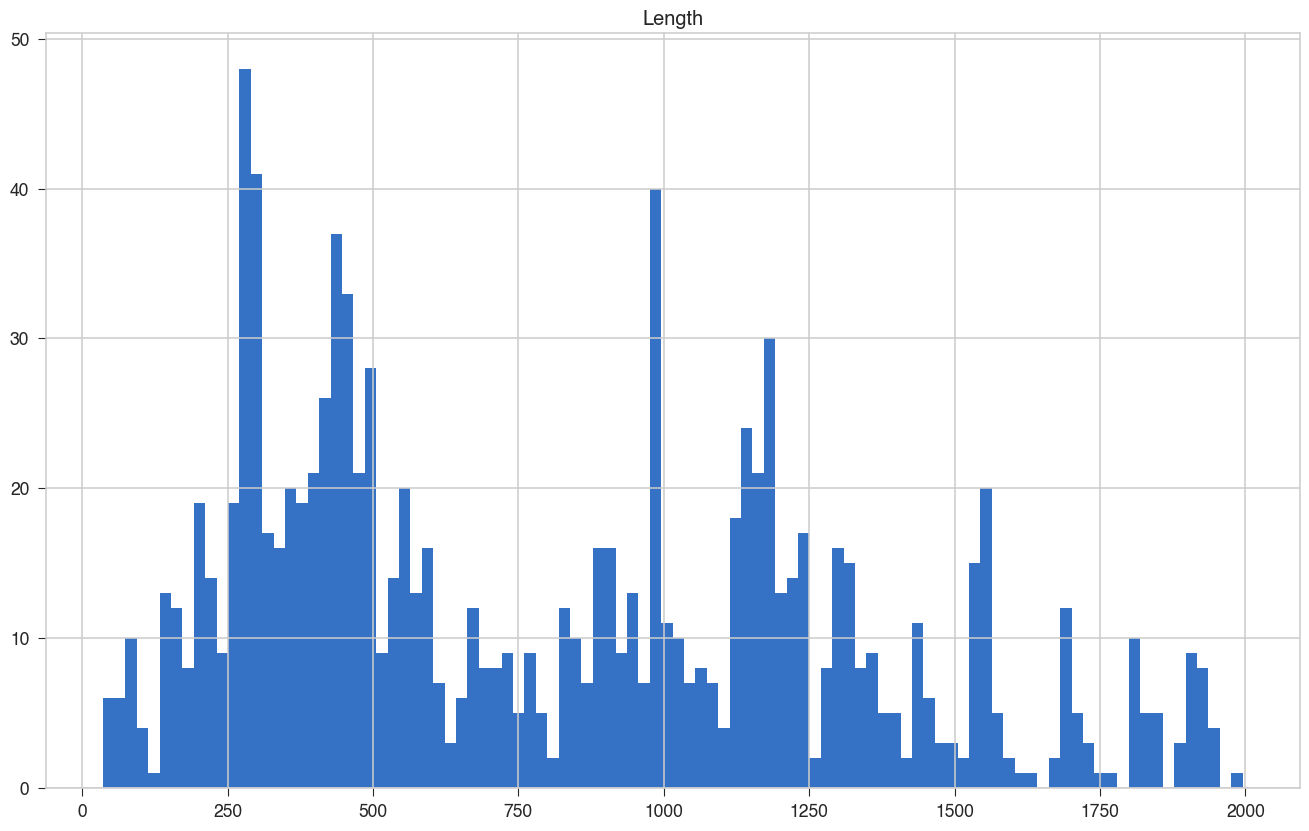

In [7]:
a.hist("Length", bins=100)

In [8]:
a.shape

(1116, 4)

In [9]:
a.columns

Index(['index', 'Protein', 'Length', 'InMembraneRatio'], dtype='object')

# I will compute the z score for those 1116 structures.

In [10]:
chosen = pd.read_csv("/Users/weilu/Research/database/relative_k/chosen_jun19.csv", index_col=0)
parser = PDBParser(PERMISSIVE=1,QUIET=True)

In [5]:
def do(cmd, get=False, show=True):
    if get:
        out = subprocess.Popen(cmd,stdout=subprocess.PIPE,shell=True).communicate()[0].decode()
        if show:
            print(out, end="")
        return out
    else:
        return subprocess.Popen(cmd, shell=True).wait()

In [7]:
fromPre = "/Users/weilu/Research/database/hybrid_contact_database/"
toPre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/"
pdb_list = chosen.Protein.tolist()

pre = toPre

do(f"mkdir -p {pre}")
do(f"mkdir -p {pre}/optimization")
do(f"mkdir -p {pre}/phis")
do(f"mkdir -p {pre}/database/dompdb")
do(f"mkdir -p {pre}/database/S20_seq")

for pdb in pdb_list:
    fromLocation = f'{fromPre}/cleaned/{pdb}.pdb'
    toLocation = f"{toPre}/database/dompdb/"
    cmd = f"cp {fromLocation} {toLocation}"
    do(cmd)
    # print(cmd)


In [9]:
for pdb in pdb_list:
    fromLocation = f'{fromPre}/cleaned/{pdb}.pdb'
#     toLocation = f"{toPre}/dompdb/"
#     os.system(f"cp {fromLocation} {toLocation}")
    try:
        structure = parser.get_structure(pdb, fromLocation)
    except:
        print(fromLocation)
        print("cannot get ", pdb)
        continue
    seq = ""
    for res in structure.get_residues():
        resName = three_to_one(res.resname)
        seq += resName
    with open(f"{toPre}/database/S20_seq/{pdb}.seq", "w") as out:
        out.write(seq+"\n")


In [10]:
np.random.shuffle(pdb_list)
with open(f"{toPre}/optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        out.write(pdb+"\n")

In [88]:
with open("/Users/weilu/Research/server/jun_2019/relative_k/optimization/small_protein_list") as f:
    names = f.readlines()

In [199]:
l = "/Users/weilu/Research/server/nov_2019/relative_k_optimization_with_membrane/database/dompdb/3b60"
input_pdb_filename = l
structure = parse_pdb(input_pdb_filename)
res_list = get_res_list(structure)

In [207]:
z_m_low = -15
z_m_high = 15
inside_or_not_table = []
for res in res_list:
    z_loc = res["CA"].get_coord()[-1]
    if z_loc > z_m_low and z_loc < z_m_high:
        inside_or_not_table.append(1)
    else:
        inside_or_not_table.append(0)
        
rotation_axis=Vector(1,0,0)
degree = 0
radian=math.radians(degree)
translation=(0,0,10)
# Iterate through all atoms and rotate by 90 degress
rotation_matrix = rotaxis2m(radian, rotation_axis)

translation_matrix = np.array(translation, 'f')
for atom in structure.get_atoms():
    print(atom.get_coord())
    atom.transform(rotation_matrix, translation_matrix)
    print(atom.get_coord())

[-22.93099976   7.2579999  -18.86899948]
[-22.93099976   7.2579999   -8.86899948]
[-24.01499939   7.34399986 -19.88800049]
[-24.01499939   7.34399986  -9.88800049]
[-23.52700043   8.08199978 -21.13299942]
[-23.52700043   8.08199978 -11.13299942]
[-22.3579998    8.51500034 -21.18899918]
[-22.3579998    8.51500034 -11.18899918]
[-25.22299957   8.09399986 -19.30699921]
[-25.22299957   8.09399986  -9.30699921]
[-26.43400002   8.10700035 -20.20599937]
[-26.43400002   8.10700035 -10.20599937]
[-27.24500084   7.04799986 -20.5       ]
[-27.24500084   7.04799986 -10.5       ]
[-26.95400047   9.22500038 -20.93499947]
[-26.95400047   9.22500038 -10.93499947]
[-28.23699951   7.4380002  -21.36599922]
[-28.23699951   7.4380002  -11.36599922]
[-28.08099937   8.77099991 -21.65200043]
[-28.08099937   8.77099991 -11.65200043]
[-26.5739994   10.56999969 -21.05699921]
[-26.5739994   10.56999969 -11.05699921]
[-28.8390007    9.61100006 -22.47800064]
[-28.8390007    9.61100006 -12.47800064]
[-27.32900047  1

[ -4.49700022 -18.11800003   8.14999998]
[ -2.26399994 -17.45000076   0.70899999]
[ -2.26399994 -17.45000076  10.70899999]
[ -1.53900003 -16.40800095  -0.153     ]
[ -1.53900003 -16.40800095   9.847     ]
[ -0.243      -15.98799992   0.537     ]
[ -0.243      -15.98799992  10.537     ]
[ -1.26300001 -16.97100067  -1.54700005]
[ -1.26300001 -16.97100067   8.45299995]
[ -3.10899997 -19.69799995  -1.08200002]
[ -3.10899997 -19.69799995   8.91799998]
[ -3.15899992 -20.43499947  -2.33999991]
[ -3.15899992 -20.43499947   7.66000009]
[ -4.57800007 -20.45899963  -2.86199999]
[ -4.57800007 -20.45899963   7.13800001]
[ -4.86600018 -19.88599968  -3.90700006]
[ -4.86600018 -19.88599968   6.09299994]
[ -2.67199993 -21.87199974  -2.17000008]
[ -2.67199993 -21.87199974   7.82999992]
[ -1.18499994 -21.98900032  -1.949     ]
[ -1.18499994 -21.98900032   8.051     ]
[ -0.27700001 -20.95000076  -3.08400011]
[ -0.27700001 -20.95000076   6.91599989]
[  0.35800001 -19.6779995   -1.99399996]
[  0.35800001 -1

[ -4.65799999  -0.89600003 -19.38500023]
[ -4.1329999   -2.14700007 -30.03199959]
[ -4.1329999   -2.14700007 -20.03199959]
[ -4.31899977  -3.35700011 -29.14699936]
[ -4.31899977  -3.35700011 -19.14699936]
[ -3.8499999   -3.31900001 -27.99099922]
[ -3.8499999   -3.31900001 -17.99099922]
[ -4.93200016  -4.34499979 -29.60899925]
[ -4.93200016  -4.34499979 -19.60899925]
[ -6.46500015   1.26699996 -28.13199997]
[ -6.46500015   1.26699996 -18.13199997]
[ -6.704        2.24499989 -27.08200073]
[ -6.704        2.24499989 -17.08200073]
[ -8.00500011   2.00099993 -26.32299995]
[ -8.00500011   2.00099993 -16.32299995]
[ -7.99300003   1.69299996 -25.11800003]
[ -7.99300003   1.69299996 -15.11800003]
[ -6.73999977   3.65199995 -27.67300034]
[ -6.73999977   3.65199995 -17.67300034]
[ -5.454        4.08300018 -28.33799934]
[ -5.454        4.08300018 -18.33799934]
[ -4.28399992   4.125      -27.37800026]
[ -4.28399992   4.125      -17.37800026]
[ -3.77399993   3.08299994 -26.95299911]
[ -3.77399993   

[ -8.64700031  15.67800045 -34.55699921]
[ -8.64700031  15.67800045 -24.55699921]
[ -5.47399998  13.8920002  -30.97500038]
[ -5.47399998  13.8920002  -20.97500038]
[ -4.45200014  14.39099979 -31.88599968]
[ -4.45200014  14.39099979 -21.88599968]
[ -3.2980001   13.40499973 -31.87999916]
[ -3.2980001   13.40499973 -21.87999916]
[ -2.69700003  13.13500023 -32.92100143]
[ -2.69700003  13.13500023 -22.92100143]
[ -3.93799996  15.76599979 -31.44499969]
[ -3.93799996  15.76599979 -21.44499969]
[ -5.03999996  16.80699921 -31.36000061]
[ -5.03999996  16.80699921 -21.36000061]
[ -5.79899979  17.00600052 -32.3030014 ]
[ -5.79899979  17.00600052 -22.3030014 ]
[ -5.12300014  17.4829998  -30.22200012]
[ -5.12300014  17.4829998  -20.22200012]
[ -3.00099993  12.86499977 -30.6970005 ]
[ -3.00099993  12.86499977 -20.6970005 ]
[ -1.90900004  11.91100025 -30.54800034]
[ -1.90900004  11.91100025 -20.54800034]
[ -2.13700008  10.75300026 -31.50699997]
[ -2.13700008  10.75300026 -21.50699997]
[ -1.18700004  1

[-8.92199993 17.97500038 19.41399956]
[-9.00300026 17.15699959 10.69099998]
[-9.00300026 17.15699959 20.69099998]
[-10.06999969  17.58600044   8.5010004 ]
[-10.06999969  17.58600044  18.5010004 ]
[-6.7329998  20.08499908 10.48999977]
[-6.7329998  20.08499908 20.48999977]
[-5.74599981 20.45999908 11.51900005]
[-5.74599981 20.45999908 21.51900005]
[-6.03599977 21.82299995 12.16699982]
[-6.03599977 21.82299995 22.16699982]
[-5.75699997 22.03800011 13.35700035]
[-5.75699997 22.03800011 23.35700035]
[-4.32399988 20.4829998  10.94900036]
[-4.32399988 20.4829998  20.94900036]
[-3.51300001 19.22599983 11.26399994]
[-3.51300001 19.22599983 21.26399994]
[-4.08400011 18.06399918 10.4630003 ]
[-4.08400011 18.06399918 20.4630003 ]
[-2.0309999  19.4489994  10.93999958]
[-2.0309999  19.4489994  20.93999958]
[-6.59600019 22.73800087 11.38099957]
[-6.59600019 22.73800087 21.38099957]
[-6.95200014 24.08499908 11.85499954]
[-6.95200014 24.08499908 21.85499954]
[-8.15499973 24.06100082 12.81700039]
[-8.15

[-30.22999954 -14.14700031 -57.93699646]
[-30.32799911 -14.05700016 -69.38700104]
[-30.32799911 -14.05700016 -59.38700104]
[-31.2840004  -14.63300037 -70.10800171]
[-31.2840004  -14.63300037 -60.10800171]
[-32.23099899 -15.34500027 -69.51000214]
[-32.23099899 -15.34500027 -59.51000214]
[-31.29400063 -14.49699974 -71.42900085]
[-31.29400063 -14.49699974 -61.42900085]
[-28.72400093 -11.86100006 -66.7460022 ]
[-28.72400093 -11.86100006 -56.7460022 ]
[-28.22299957 -10.61400032 -67.2519989 ]
[-28.22299957 -10.61400032 -57.2519989 ]
[-28.1590004  -10.31499958 -68.7460022 ]
[-28.1590004  -10.31499958 -58.7460022 ]
[-27.3579998   -9.37800026 -69.0039978 ]
[-27.3579998   -9.37800026 -59.0039978 ]
[-26.87599945 -10.26599979 -66.57800293]
[-26.87599945 -10.26599979 -56.57800293]
[-28.79299927 -11.08600044 -69.7539978 ]
[-28.79299927 -11.08600044 -59.7539978 ]
[-28.68300056 -10.22599983 -70.93699646]
[-28.68300056 -10.22599983 -60.93699646]
[-28.08399963  -8.85000038 -70.6989975 ]
[-28.08399963  -

[-29.06599998   5.36000013 -59.02600098]
[-29.06599998   5.36000013 -49.02600098]
[-29.8579998    6.30800009 -59.80099869]
[-29.8579998    6.30800009 -49.80099869]
[-29.36199951   7.07299995 -60.76599884]
[-29.36199951   7.07299995 -50.76599884]
[-28.07699966   6.99599981 -61.0719986 ]
[-28.07699966   6.99599981 -51.0719986 ]
[-30.14699936   7.921      -61.41699982]
[-30.14699936   7.921      -51.41699982]
[-32.35900116   1.32200003 -59.02600098]
[-32.35900116   1.32200003 -49.02600098]
[-33.44400024   0.35100001 -58.89699936]
[-33.44400024   0.35100001 -48.89699936]
[-32.81700134  -0.96399999 -58.46099854]
[-32.81700134  -0.96399999 -48.46099854]
[-33.37099838  -1.69099998 -57.63299942]
[-33.37099838  -1.69099998 -47.63299942]
[-34.17499924   0.14300001 -60.24200058]
[-34.17499924   0.14300001 -50.24200058]
[-35.0359993    1.31500006 -60.73099899]
[-35.0359993    1.31500006 -50.73099899]
[-35.8390007    0.98500001 -61.99000168]
[-35.8390007    0.98500001 -51.99000168]
[-3.66419983e+01

[  1.852       -6.42600012 -58.21500015]
[  1.852       -6.42600012 -48.21500015]
[  0.31799999  -5.61399984 -56.11999893]
[  0.31799999  -5.61399984 -46.11999893]
[ -0.212       -4.71600008 -57.22299957]
[ -0.212       -4.71600008 -47.22299957]
[ -1.11500001  -5.10099983 -57.9679985 ]
[ -1.11500001  -5.10099983 -47.9679985 ]
[  0.336       -3.5150001  -57.33100128]
[  0.336       -3.5150001  -47.33100128]
[  1.125       -8.55700016 -58.22499847]
[  1.125       -8.55700016 -48.22499847]
[  1.91600001  -8.9659996  -59.36199951]
[  1.91600001  -8.9659996  -49.36199951]
[  3.29299998  -8.34799957 -59.36999893]
[  3.29299998  -8.34799957 -49.36999893]
[  3.66499996  -7.70499992 -60.34899902]
[  3.66499996  -7.70499992 -50.34899902]
[  4.06400013  -8.51900005 -58.3030014 ]
[  4.06400013  -8.51900005 -48.3030014 ]
[  5.39300013  -7.92399979 -58.29499817]
[  5.39300013  -7.92399979 -48.29499817]
[  6.44000006  -8.82600021 -58.91799927]
[  6.44000006  -8.82600021 -48.91799927]
[  7.31500006  -

[-13.4630003   14.81999969 -65.59100342]
[-14.61999989  15.22700024 -75.65000153]
[-14.61999989  15.22700024 -65.65000153]
[-12.36200047  14.45400047 -77.77799988]
[-12.36200047  14.45400047 -67.77799988]
[-11.04699993  15.11800003 -77.46199799]
[-11.04699993  15.11800003 -67.46199799]
[-10.64599991  16.12599945 -78.4960022 ]
[-10.64599991  16.12599945 -68.4960022 ]
[-10.65299988  15.78100014 -79.69400024]
[-10.65299988  15.78100014 -69.69400024]
[-10.32199955  17.26499939 -78.10900116]
[-10.32199955  17.26499939 -68.10900116]
[-12.57199955  15.24100018 -74.69999695]
[-12.57199955  15.24100018 -64.69999695]
[-12.85299969  16.23999977 -73.68399811]
[-12.85299969  16.23999977 -63.68399811]
[-14.18799973  16.01399994 -72.98999786]
[-14.18799973  16.01399994 -62.98999786]
[-15.13000011  16.78100014 -73.17500305]
[-15.13000011  16.78100014 -63.17500305]
[-12.78999996  17.64800072 -74.29599762]
[-12.78999996  17.64800072 -64.29599762]
[-12.51900005  18.7310009  -73.25700378]
[-12.51900005  1

[-2.67799997 11.66499996 25.10900021]
[-3.73300004 10.66499996 14.95600033]
[-3.73300004 10.66499996 24.95600033]
[-4.49499989 10.5340004  16.28000069]
[-4.49499989 10.5340004  26.28000069]
[-5.51300001 11.19699955 16.48999977]
[-5.51300001 11.19699955 26.48999977]
[-3.11899996  9.31400013 14.56999969]
[-3.11899996  9.31400013 24.56999969]
[-4.02099991  8.15799999 14.13300037]
[-4.02099991  8.15799999 24.13300037]
[-4.70900011  8.51399994 12.81900024]
[-4.70900011  8.51399994 22.81900024]
[-3.18000007  6.89499998 13.96899986]
[-3.18000007  6.89499998 23.96899986]
[-3.98099995  9.68099976 17.16699982]
[-3.98099995  9.68099976 27.16699982]
[-4.58300018  9.43900013 18.47800064]
[-4.58300018  9.43900013 28.47800064]
[-4.1789999  10.48400021 19.52499962]
[-4.1789999  10.48400021 29.52499962]
[-4.99399996 10.87699986 20.36199951]
[-4.99399996 10.87699986 30.36199951]
[-4.21600008  8.02799988 18.96500015]
[-4.21600008  8.02799988 28.96500015]
[-2.73699999  7.71400023 18.79899979]
[-2.73699999

[ 11.06299973  -7.96799994 -44.90499878]
[ 11.65200043  -7.04899979 -54.29899979]
[ 11.65200043  -7.04899979 -44.29899979]
[ 11.03100014  -8.04199982 -56.15100098]
[ 11.03100014  -8.04199982 -46.15100098]
[  9.57499981 -10.24600029 -51.45800018]
[  9.57499981 -10.24600029 -41.45800018]
[  9.07499981 -11.35000038 -50.6609993 ]
[  9.07499981 -11.35000038 -40.6609993 ]
[  7.91499996 -11.04100037 -49.7179985 ]
[  7.91499996 -11.04100037 -39.7179985 ]
[  6.76599979 -11.33100033 -50.05199814]
[  6.76599979 -11.33100033 -40.05199814]
[ 10.22999954 -12.00300026 -49.90299988]
[ 10.22999954 -12.00300026 -39.90299988]
[ 11.30900002 -12.56700039 -50.82799911]
[ 11.30900002 -12.56700039 -40.82799911]
[ 10.70699978 -13.42700005 -51.94599915]
[ 10.70699978 -13.42700005 -41.94599915]
[ 11.77400017 -14.14799976 -52.77500153]
[ 11.77400017 -14.14799976 -42.77500153]
[ 12.71899986 -13.22999954 -53.47700119]
[ 12.71899986 -13.22999954 -43.47700119]
[  8.18299961 -10.4460001  -48.55699921]
[  8.18299961 -1

[  9.49100018 -13.32600021 -24.50600052]
[  9.49100018 -13.32600021 -14.50600052]
[  8.83899975 -13.92000008 -25.75099945]
[  8.83899975 -13.92000008 -15.75099945]
[  8.52499962 -13.20800018 -26.70499992]
[  8.52499962 -13.20800018 -16.70499992]
[ 10.95600033 -13.77499962 -24.45899963]
[ 10.95600033 -13.77499962 -14.45899963]
[ 11.72700024 -13.37699986 -23.21199989]
[ 11.72700024 -13.37699986 -13.21199989]
[ 13.17199993 -13.85900021 -23.3010006 ]
[ 13.17199993 -13.85900021 -13.3010006 ]
[ 13.95400047 -13.50599957 -22.11899948]
[ 13.95400047 -13.50599957 -12.11899948]
[ 15.27099991 -13.6619997  -22.02000046]
[ 15.27099991 -13.6619997  -12.02000046]
[ 15.9630003  -14.16499996 -23.0340004 ]
[ 15.9630003  -14.16499996 -13.0340004 ]
[ 15.90100002 -13.31099987 -20.90600014]
[ 15.90100002 -13.31099987 -10.90600014]
[  8.63300037 -15.2329998  -25.72200012]
[  8.63300037 -15.2329998  -15.72200012]
[  8.03499985 -15.93299961 -26.85099983]
[  8.03499985 -15.93299961 -16.85099983]
[  6.58599997 -1

[  7.91599989 -20.69199944   4.68300009]
[  9.5539999  -19.89699936  -3.61299992]
[  9.5539999  -19.89699936   6.38700008]
[  8.57600021 -20.25099945  -6.61600018]
[  8.57600021 -20.25099945   3.38399982]
[  6.61199999 -17.91900063  -1.89600003]
[  6.61199999 -17.91900063   8.10399997]
[  6.70699978 -16.90699959  -0.84200001]
[  6.70699978 -16.90699959   9.15799999]
[  6.03700018 -17.41300011   0.43099999]
[  6.03700018 -17.41300011  10.43099999]
[  6.60699987 -17.34600067   1.52699995]
[  6.60699987 -17.34600067  11.52699995]
[  6.04300022 -15.61499977  -1.29799998]
[  6.04300022 -15.61499977   8.70200002]
[  4.81899977 -17.91900063   0.273     ]
[  4.81899977 -17.91900063  10.273     ]
[  4.03499985 -18.45000076   1.38100004]
[  4.03499985 -18.45000076  11.38100004]
[  4.68400002 -19.72100067   1.93700004]
[  4.68400002 -19.72100067  11.93700004]
[  4.27899981 -20.23600006   2.98399997]
[  4.27899981 -20.23600006  12.98399997]
[  2.60800004 -18.75499916   0.90700001]
[  2.60800004 -1

[ 37.04100037  -0.121      -44.94499969]
[ 36.02500153  -1.19400001 -55.1629982 ]
[ 36.02500153  -1.19400001 -45.1629982 ]
[ 34.23600006   3.93099999 -56.42599869]
[ 34.23600006   3.93099999 -46.42599869]
[ 34.28300095   5.00500011 -57.4129982 ]
[ 34.28300095   5.00500011 -47.4129982 ]
[ 32.97900009   5.796      -57.55099869]
[ 32.97900009   5.796      -47.55099869]
[ 31.95400047   5.25899982 -57.96699905]
[ 31.95400047   5.25899982 -47.96699905]
[ 34.68000031   4.4380002  -58.78300095]
[ 34.68000031   4.4380002  -48.78300095]
[ 35.97000122   3.62199998 -58.77999878]
[ 35.97000122   3.62199998 -48.77999878]
[ 36.36199951   3.125      -60.17900085]
[ 36.36199951   3.125      -50.17900085]
[ 37.09600067   4.11600018 -60.9679985 ]
[ 37.09600067   4.11600018 -50.9679985 ]
[ 36.55099869   5.16699982 -61.57400131]
[ 36.55099869   5.16699982 -51.57400131]
[ 35.24599838   5.38700008 -61.49499893]
[ 35.24599838   5.38700008 -51.49499893]
[ 37.31600189   6.00699997 -62.26200104]
[ 37.31600189   

[ 31.86000061  -3.63899994 -63.10300064]
[ 31.86000061  -3.63899994 -53.10300064]
[ 30.67200089  -4.48600006 -62.64899826]
[ 30.67200089  -4.48600006 -52.64899826]
[ 30.02400017  -4.12900019 -61.64099884]
[ 30.02400017  -4.12900019 -51.64099884]
[ 30.38899994  -5.51499987 -63.29899979]
[ 30.38899994  -5.51499987 -53.29899979]
[ 29.35199928  -1.80799997 -62.45000076]
[ 29.35199928  -1.80799997 -52.45000076]
[ 28.48200035  -1.19000006 -61.45899963]
[ 28.48200035  -1.19000006 -51.45899963]
[ 29.07500076  -1.24899995 -60.0530014 ]
[ 29.07500076  -1.24899995 -50.0530014 ]
[ 29.02199936  -0.26499999 -59.31499863]
[ 29.02199936  -0.26499999 -49.31499863]
[ 27.10000038  -1.852      -61.48500061]
[ 27.10000038  -1.852      -51.48500061]
[ 26.15699959  -1.40699995 -62.61199951]
[ 26.15699959  -1.40699995 -52.61199951]
[ 26.81900024  -1.58899999 -63.9620018 ]
[ 26.81900024  -1.58899999 -53.9620018 ]
[ 24.87199974  -2.20799994 -62.54000092]
[ 24.87199974  -2.20799994 -52.54000092]
[ 29.64500046  -

[ -2.69799995   6.89799976 -55.0719986 ]
[ -2.69799995   6.89799976 -45.0719986 ]
[ -2.94099998   8.09399986 -52.52299881]
[ -2.94099998   8.09399986 -42.52299881]
[ -1.94700003   7.18499994 -51.79800034]
[ -1.94700003   7.18499994 -41.79800034]
[ -2.58299994   6.38000011 -50.67900085]
[ -2.58299994   6.38000011 -40.67900085]
[ -1.83800006   5.74100018 -49.90399933]
[ -1.83800006   5.74100018 -39.90399933]
[ -3.82800007   6.37799978 -50.57600021]
[ -3.82800007   6.37799978 -40.57600021]
[ -0.773        8.02499962 -55.38199997]
[ -0.773        8.02499962 -45.38199997]
[ -0.29899999   7.16099977 -56.4620018 ]
[ -0.29899999   7.16099977 -46.4620018 ]
[ -1.18599999   7.39599991 -57.67900085]
[ -1.18599999   7.39599991 -47.67900085]
[ -1.87899995   6.49499989 -58.15599823]
[ -1.87899995   6.49499989 -48.15599823]
[ -0.34         5.67999983 -56.06499863]
[ -0.34         5.67999983 -46.06499863]
[  0.175        4.77299976 -57.16999817]
[  0.175        4.77299976 -47.16999817]
[  1.08399999   

[ 23.38999939  -2.0079999  -72.22799683]
[ 22.34300041  -3.727      -81.35500336]
[ 22.34300041  -3.727      -71.35500336]
[ 17.86400032  -1.93599999 -82.50700378]
[ 17.86400032  -1.93599999 -72.50700378]
[ 16.78499985  -2.65199995 -81.84300232]
[ 16.78499985  -2.65199995 -71.84300232]
[ 17.21100044  -4.05100012 -81.41899872]
[ 17.21100044  -4.05100012 -71.41899872]
[ 17.65299988  -4.86000013 -82.24099731]
[ 17.65299988  -4.86000013 -72.24099731]
[ 15.55099964  -2.77699995 -82.75900269]
[ 15.55099964  -2.77699995 -72.75900269]
[ 15.05500031  -1.39100003 -83.1760025 ]
[ 15.05500031  -1.39100003 -73.1760025 ]
[ 14.4460001   -3.51900005 -82.03700256]
[ 14.4460001   -3.51900005 -72.03700256]
[ 15.86800003  -0.73900002 -84.26999664]
[ 15.86800003  -0.73900002 -74.26999664]
[ 17.06399918  -4.33199978 -80.1289978 ]
[ 17.06399918  -4.33199978 -70.1289978 ]
[ 17.43199921  -5.62900019 -79.58699799]
[ 17.43199921  -5.62900019 -69.58699799]
[ 16.22299957  -6.53100014 -79.40899658]
[ 16.22299957  -

In [212]:
[60] * 6

[60, 60, 60, 60, 60, 60]

In [202]:
count = 0
# res_list = get_res_list(structure)
for i, res in enumerate(res_list):
    z_loc = res["CA"].get_coord()[-1]
    if z_loc > z_m_low and z_loc < z_m_high:
        is_inside = 1
    else:
        is_inside = 0
    if is_inside == inside_or_not_table[i]:
        count += 1
print(count, count/len(inside_or_not_table))

1144 1.0


In [28]:
pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_with_burial_and_membrane"
phi_pre = "phi_relative_k_with_membrane_well"
with open(f"{pre}/optimization/protein_list") as f:
    names = f.readlines()
names = [i.strip() for i in names]

In [29]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
name = names[0]
cutoff = 1.0
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
# value_list, value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)


In [120]:
def get_relative_k_data(gamma, decoy, decoyQ, native):
    # gamma = 1
    limit =30
    energy = [a[0]+(a[1]+a[2])*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = np.arange(-limit, limit, 1)
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    # d = d.sort_values("z_m").reset_index()
    native_energy =native[0] + (native[2]+native[1])*gamma
    d["native"] = native_energy
    d["z"] = native_energy/d["energy"]
    d["z"] = (d["energy"] - native_energy)/d["energy"].std()
    # d = d.query("z_m != 0").reset_index(drop=True)
    # d = d.query("abs(z_m) >= 5").reset_index(drop=True)
    # dz = d["z"].tolist()
    return d
def get_value_3(gamma, decoy, decoyQ, native, cutoff=0):
    d = get_relative_k_data(gamma, decoy, decoyQ, native)
    
    # dz = d["z"].tolist()
    value = ( ((d["z"] >= cutoff)) ).sum()/len(d)
    value_sum =  ((d["z"]) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    return value, value_sum

def get_value_array_3(gamma_list, **kwargs):
    # gamma_list = np.linspace(1,15, num=100)
    value_list = []
    value_sum_list = []
    for gamma in gamma_list:
        value, value_sum = get_value_3(gamma, **kwargs)
        # value, value_sum = get_value(gamma, **kwargs)
        # print(gamma, value)
        value_list.append(value)
        value_sum_list.append(value_sum)
    return np.array(value_list), np.array(value_sum_list)

In [104]:
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_with_burial_and_membrane"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/phis"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/back_phis/"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(0,3, num=50)
cutoff = 0
all_value_list = []
all_value_sum_list = []
cc = 0
for i, name in enumerate(names):
    cc += 1
    if i % 100 == 20:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array_3(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

20


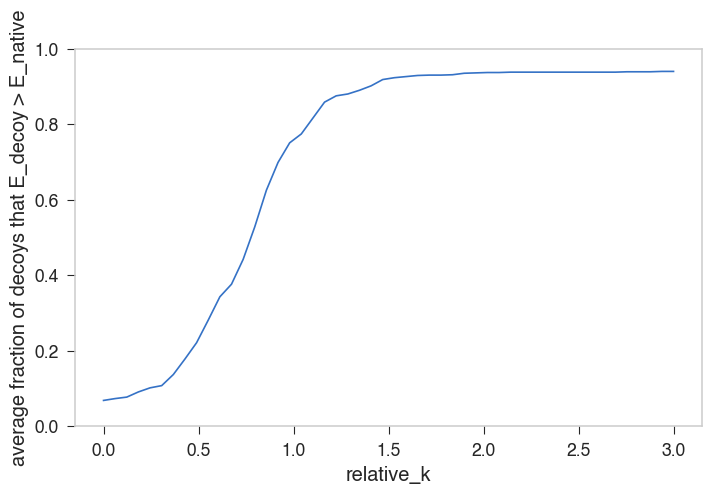

In [109]:

plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})


a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that E_decoy > E_native")
plt.ylim((0,1))
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

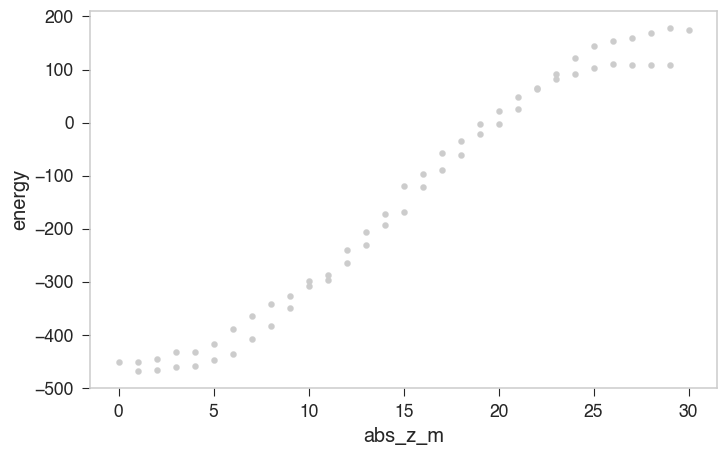

In [126]:
def get_relative_k_data_alpha(gamma, decoy, decoyQ, native):
    # gamma = 1
    limit =30
    energy = [a[0]*(1-gamma)+(a[1]+a[2])*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = np.arange(-limit, limit, 1)
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    # d = d.sort_values("z_m").reset_index()
    native_energy =native[0]*(1-gamma) + (native[2]+native[1])*gamma
    d["native"] = native_energy
    d["z"] = native_energy/d["energy"]
    d["z"] = (d["energy"] - native_energy)/d["energy"].std()
    # d = d.query("z_m != 0").reset_index(drop=True)
    # d = d.query("abs(z_m) >= 5").reset_index(drop=True)
    # dz = d["z"].tolist()
    return d

# relative k =1 
name = names[1]
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
d = get_relative_k_data_alpha(1, decoy=decoy, decoyQ=decoyQ, native=native)
d["abs_z_m"] = abs(d["z_m"])
d.plot.scatter("abs_z_m", "energy")

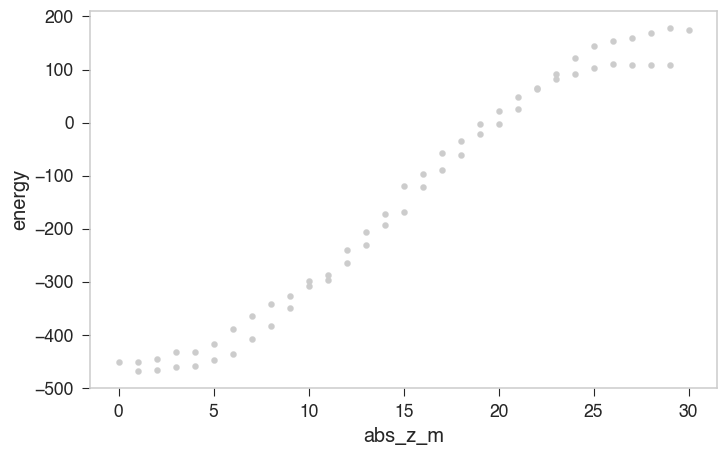

In [128]:
def get_relative_k_data_alpha(gamma, decoy, decoyQ, native):
    # gamma = 1
    limit =30
    energy = [a[0]*(1-gamma)+(a[1]+a[2])*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = np.arange(-limit, limit, 1)
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    # d = d.sort_values("z_m").reset_index()
    native_energy =native[0]*(1-gamma) + (native[2]+native[1])*gamma
    d["native"] = native_energy
    d["z"] = native_energy/d["energy"]
    d["z"] = (d["energy"] - native_energy)/d["energy"].std()
    # d = d.query("z_m != 0").reset_index(drop=True)
    # d = d.query("abs(z_m) >= 5").reset_index(drop=True)
    # dz = d["z"].tolist()
    return d

# relative k =1 
name = names[1]
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
d = get_relative_k_data_alpha(1, decoy=decoy, decoyQ=decoyQ, native=native)
d["abs_z_m"] = abs(d["z_m"])
d.plot.scatter("abs_z_m", "energy")

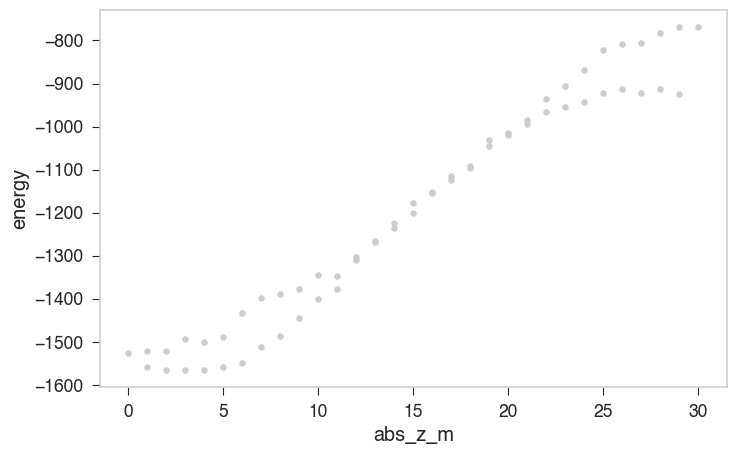

In [122]:
# relative k = 2
name = names[1]
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
d = get_relative_k_data(2, decoy=decoy, decoyQ=decoyQ, native=native)
d["abs_z_m"] = abs(d["z_m"])
d.plot.scatter("abs_z_m", "energy")

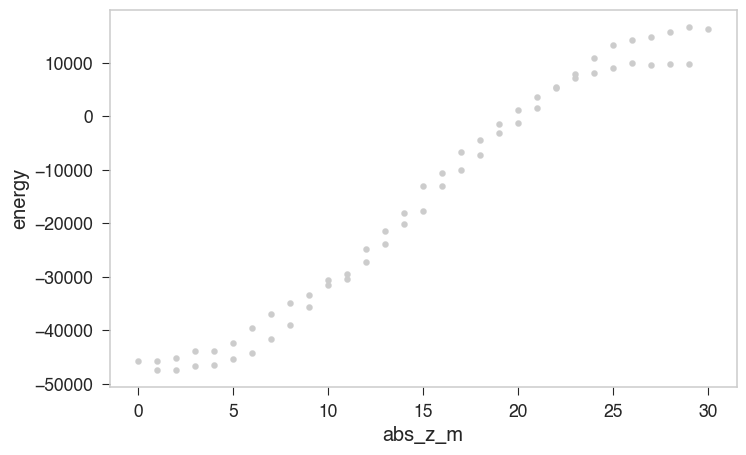

In [124]:
# relative k = 2
relative_k = 100
name = names[1]
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
d = get_relative_k_data(relative_k, decoy=decoy, decoyQ=decoyQ, native=native)
d["abs_z_m"] = abs(d["z_m"])
d.plot.scatter("abs_z_m", "energy")

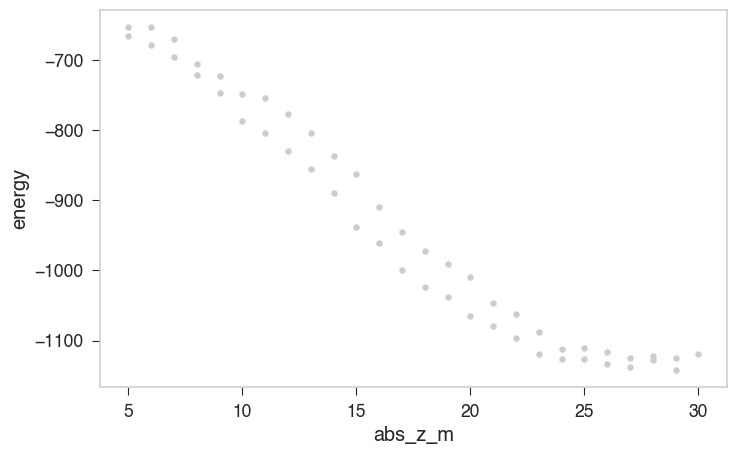

In [117]:
d["abs_z_m"] = abs(d["z_m"])
d.plot.scatter("abs_z_m", "energy")

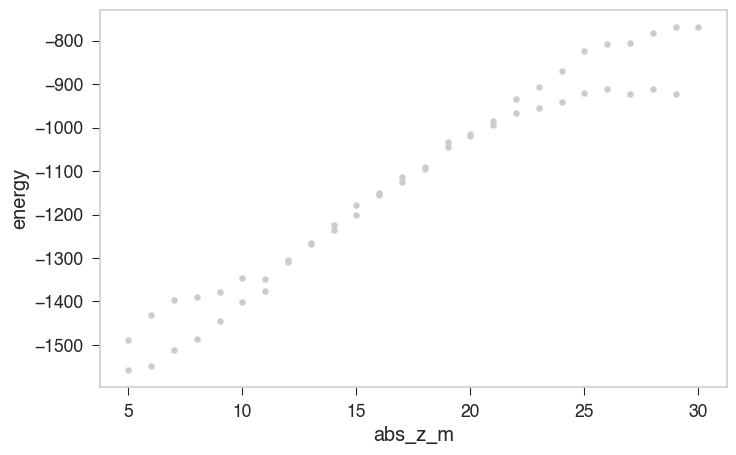

In [115]:
d.plot.scatter("abs_z_m", "energy")

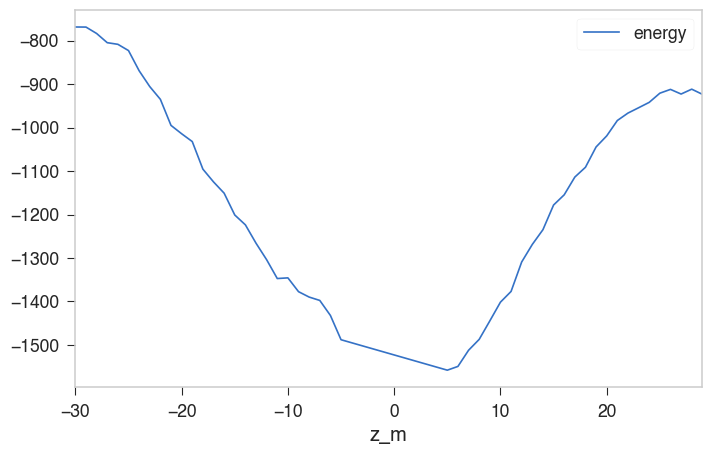

In [111]:
d.plot("z_m", "energy")

In [118]:
name = names[1]
decoy = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phis/{phi_pre}_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
d = get_relative_k_data(1, decoy=decoy, decoyQ=decoyQ, native=native)
d

,z_m,energy,Q,native,z
0,-30.0,-943.8827,0.0000,-1075.4507,3.150069
1,-29.0,-947.1971,0.0001,-1075.4507,3.070714
2,-28.0,-952.8465,0.0001,-1075.4507,2.935453
3,-27.0,-964.8886,0.0002,-1075.4507,2.647135
4,-26.0,-962.4638,0.0002,-1075.4507,2.705191
5,-25.0,-966.6158,0.0003,-1075.4507,2.605781
6,-24.0,-990.3614,0.0005,-1075.4507,2.037252
7,-23.0,-996.6935,0.0008,-1075.4507,1.885645
8,-22.0,-998.7021,0.0011,-1075.4507,1.837555
9,-21.0,-1020.5514,0.0017,-1075.4507,1.314427


,z_m,energy,Q,native,z
0,-30.0,-768.7444,0.0000,-1525.6811,2.911356
1,-29.0,-768.9475,0.0001,-1525.6811,2.910575
2,-28.0,-783.6661,0.0001,-1525.6811,2.853964
3,-27.0,-804.8482,0.0002,-1525.6811,2.772493
4,-26.0,-808.5686,0.0002,-1525.6811,2.758183
5,-25.0,-822.9620,0.0003,-1525.6811,2.702823
6,-24.0,-869.3310,0.0005,-1525.6811,2.524477
7,-23.0,-905.7683,0.0008,-1525.6811,2.384330
8,-22.0,-935.1202,0.0011,-1525.6811,2.271436
9,-21.0,-995.0494,0.0017,-1525.6811,2.040934


In [58]:
name

'4pgr'

In [ ]:
def get_relative_k_data(gamma, decoy, decoyQ, native, cutoff=0.95):
    # gamma = 1
    limit =30
    energy = [a[0]+a[1]*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = list(np.arange(5, limit, 1)) + list(np.arange(-limit, -5, 1))
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    d = d.sort_values("z_m").reset_index()
    native_energy =native[0] + native[1]*gamma
    d["native"] = native_energy
    d["z"] = native_energy/d["energy"]
    # dz = d["z"].tolist()
    return d
def get_value(gamma, decoy, decoyQ, native, cutoff=0.95):
    # gamma = 1
    limit =30
    energy = [a[0]+a[1]*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = list(np.arange(5, limit, 1)) + list(np.arange(-limit, -5, 1))
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    d = d.sort_values("z_m").reset_index()
    native_energy =native[0] + native[1]*gamma
    d["z"] = native_energy/d["energy"]
    d["z_real"] = (native_energy-d["energy"])/d["energy"].std()
    # dz = d["z"].tolist()
    value = ( ((d["z"] > cutoff)) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    value_sum =  ((d["z"]) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    return value, value_sum

def get_value_2(gamma, decoy, decoyQ, native, cutoff=0):
    # gamma = 1
    limit =30
    energy = [a[0]+a[1]*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = list(np.arange(5, limit, 1)) + list(np.arange(-limit, -5, 1))
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    d = d.sort_values("z_m").reset_index()
    native_energy =native[0] + native[1]*gamma
    # d["z"] = native_energy/d["energy"]
    d["z"] = (native_energy-d["energy"])/d["energy"].std()
    # dz = d["z"].tolist()
    value = ( ((d["z"] > cutoff)) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    value_sum =  ((d["z"]) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    return value, value_sum

def get_value_3(gamma, decoy, decoyQ, native, cutoff=0):
    # gamma = 1
    limit =30
    energy = [a[0]+a[1]*gamma for a in decoy]
    # z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
    z_m = list(np.arange(5, limit, 1)) + list(np.arange(-limit, -5, 1))
    d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
    d.columns = ["z_m", "energy", "Q"]
    d = d.sort_values("z_m").reset_index()
    native_energy =native[0] + native[1]*gamma
    # d["z"] = native_energy/d["energy"]
    d["z"] = (native_energy-d["energy"])/d["energy"].std()
    # dz = d["z"].tolist()
    value = ( ((d["z"] > cutoff)) ).sum()/len(d)
    value_sum =  ((d["z"]) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
    return value, value_sum

def get_value_array(gamma_list, **kwargs):
    # gamma_list = np.linspace(1,15, num=100)
    value_list = []
    value_sum_list = []
    for gamma in gamma_list:
        value, value_sum = get_value_2(gamma, **kwargs)
        # value, value_sum = get_value(gamma, **kwargs)
        # print(gamma, value)
        value_list.append(value)
        value_sum_list.append(value_sum)
    return np.array(value_list), np.array(value_sum_list)

def get_value_array_3(gamma_list, **kwargs):
    # gamma_list = np.linspace(1,15, num=100)
    value_list = []
    value_sum_list = []
    for gamma in gamma_list:
        value, value_sum = get_value_3(gamma, **kwargs)
        # value, value_sum = get_value(gamma, **kwargs)
        # print(gamma, value)
        value_list.append(value)
        value_sum_list.append(value_sum)
    return np.array(value_list), np.array(value_sum_list)

In [194]:
pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/phis"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/back_phis/"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(1,10, num=50)
cutoff = 1.0
all_value_list = []
all_value_sum_list = []
for i, name in enumerate(names):
    cc += 1
    if i % 100 == 20:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array_3(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

20


(0, 1)

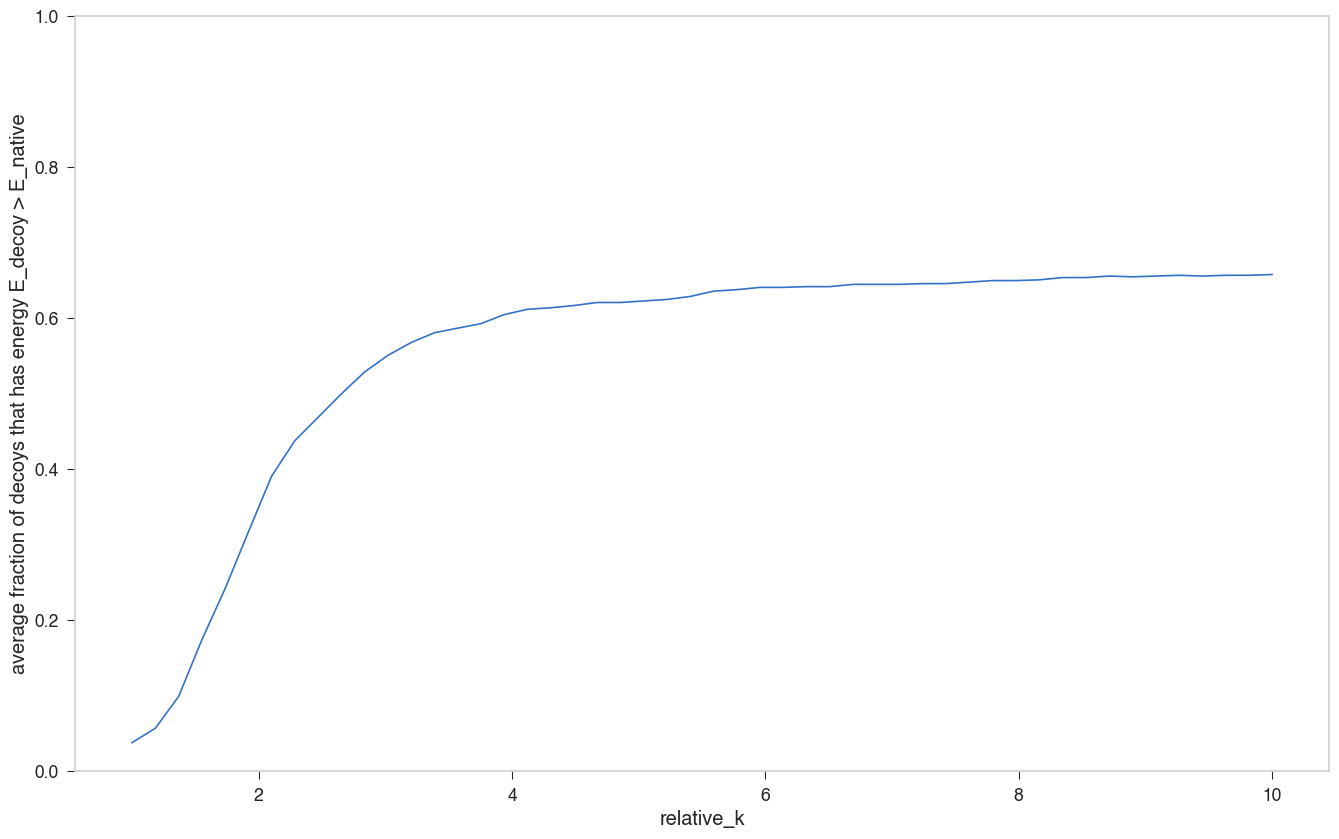

In [196]:
a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

(0, 1)

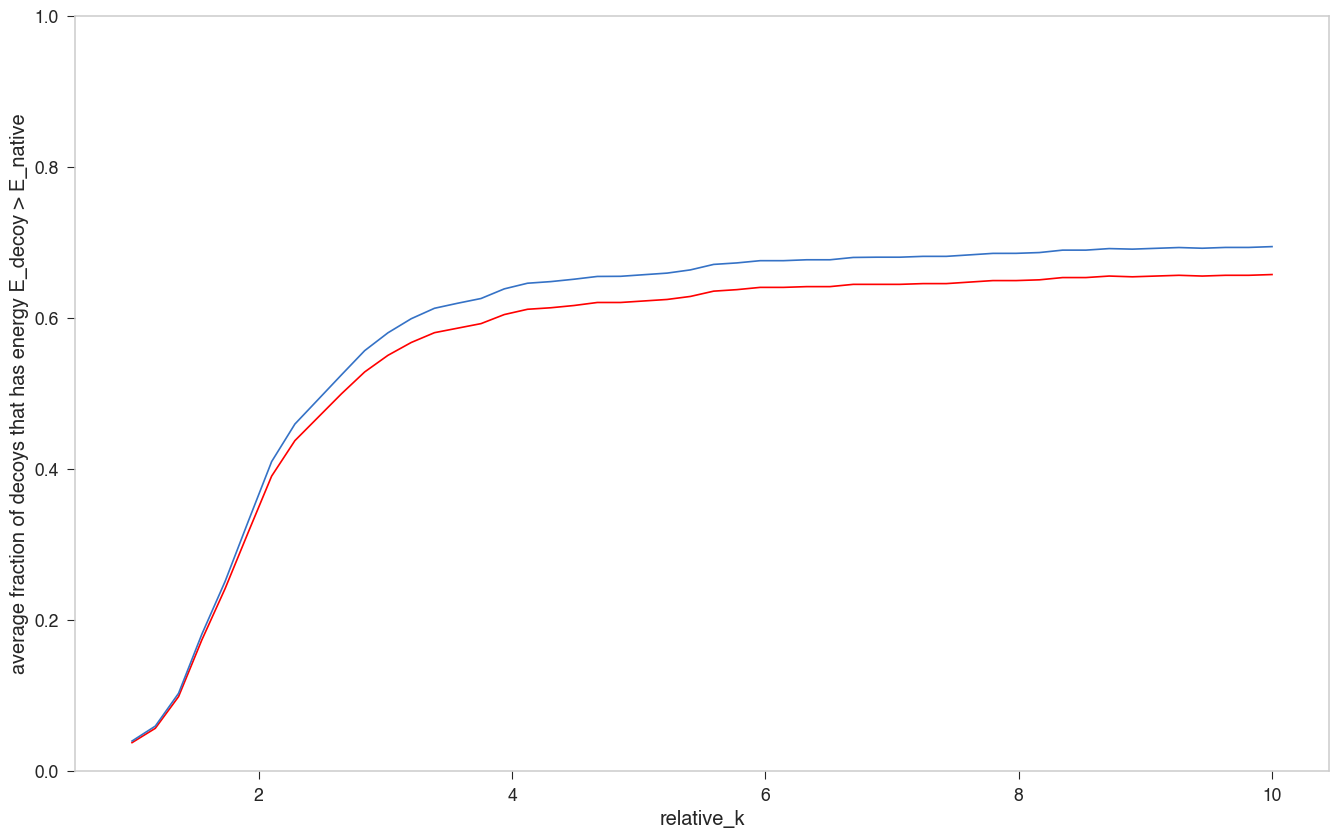

In [200]:
# a_3 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3, color="red")
plt.plot(gamma_list, a_2)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

In [197]:
pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/phis"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/back_phis/"
# pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(1,10, num=50)
cutoff = 1.0
all_value_list = []
all_value_sum_list = []
for i, name in enumerate(names):
    cc += 1
    if i % 100 == 20:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

20


(0, 1)

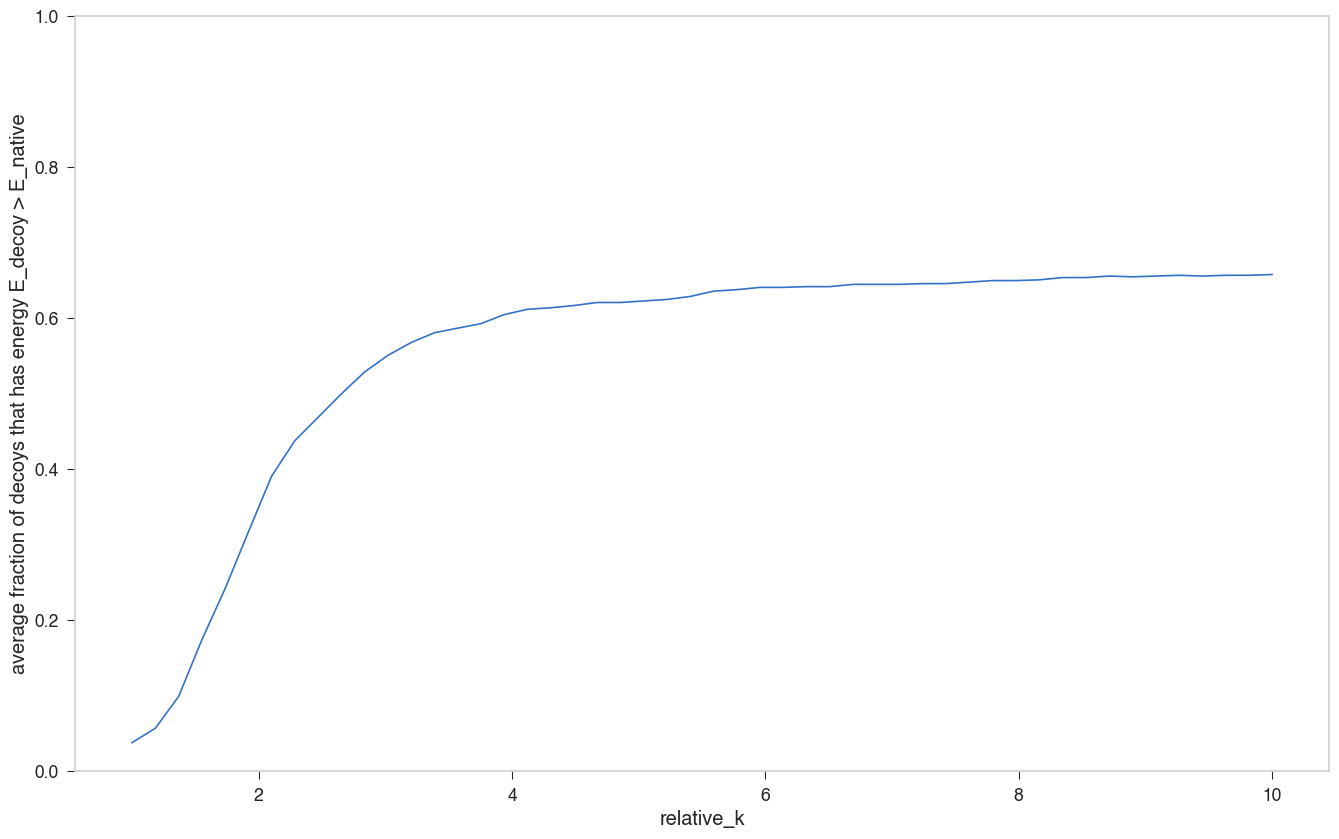

In [198]:
a_2 = pd.DataFrame(all_value_list).sum(axis=0)/20
plt.plot(gamma_list, a_3)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

(0, 1)

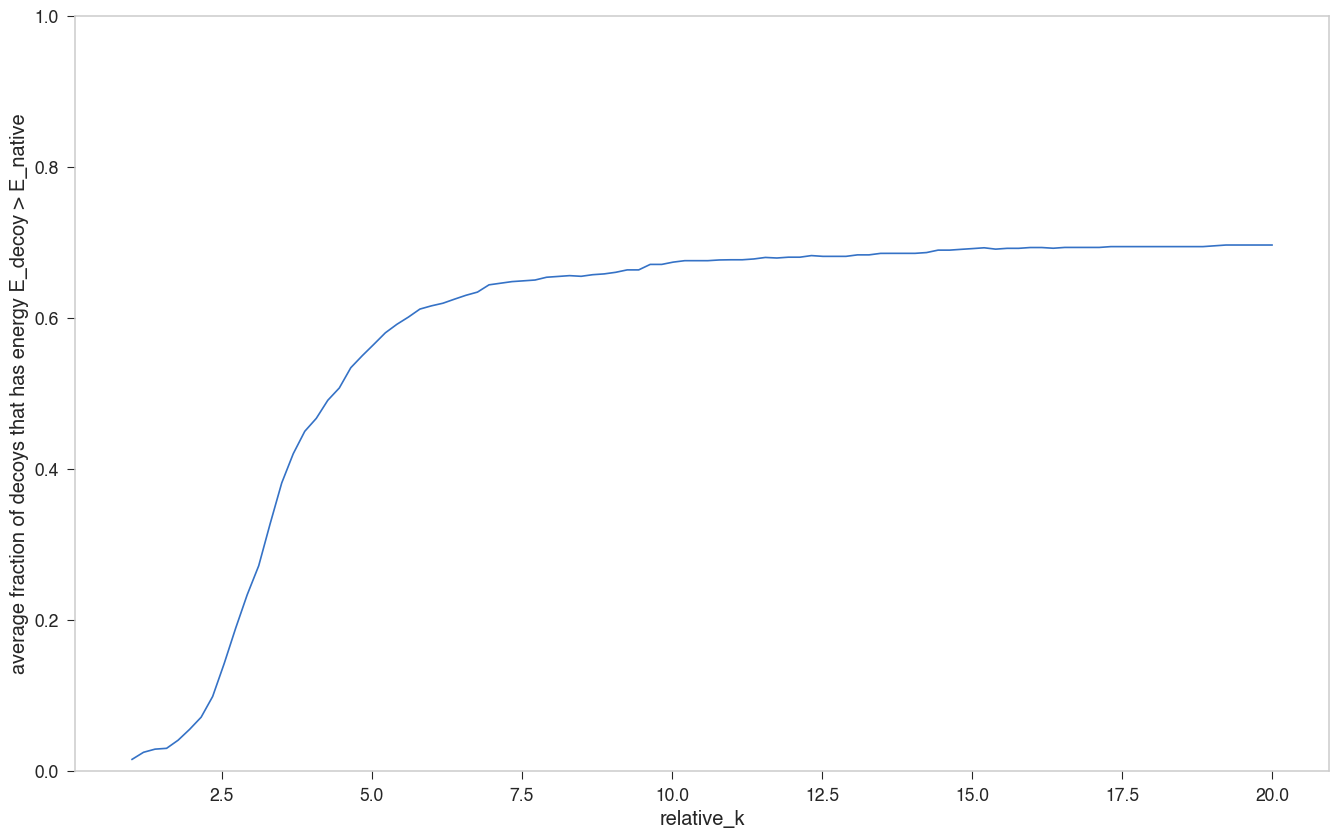

In [168]:
plt.plot(gamma_list, pd.DataFrame(all_value_list).sum(axis=0)/20)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

(0, 1)

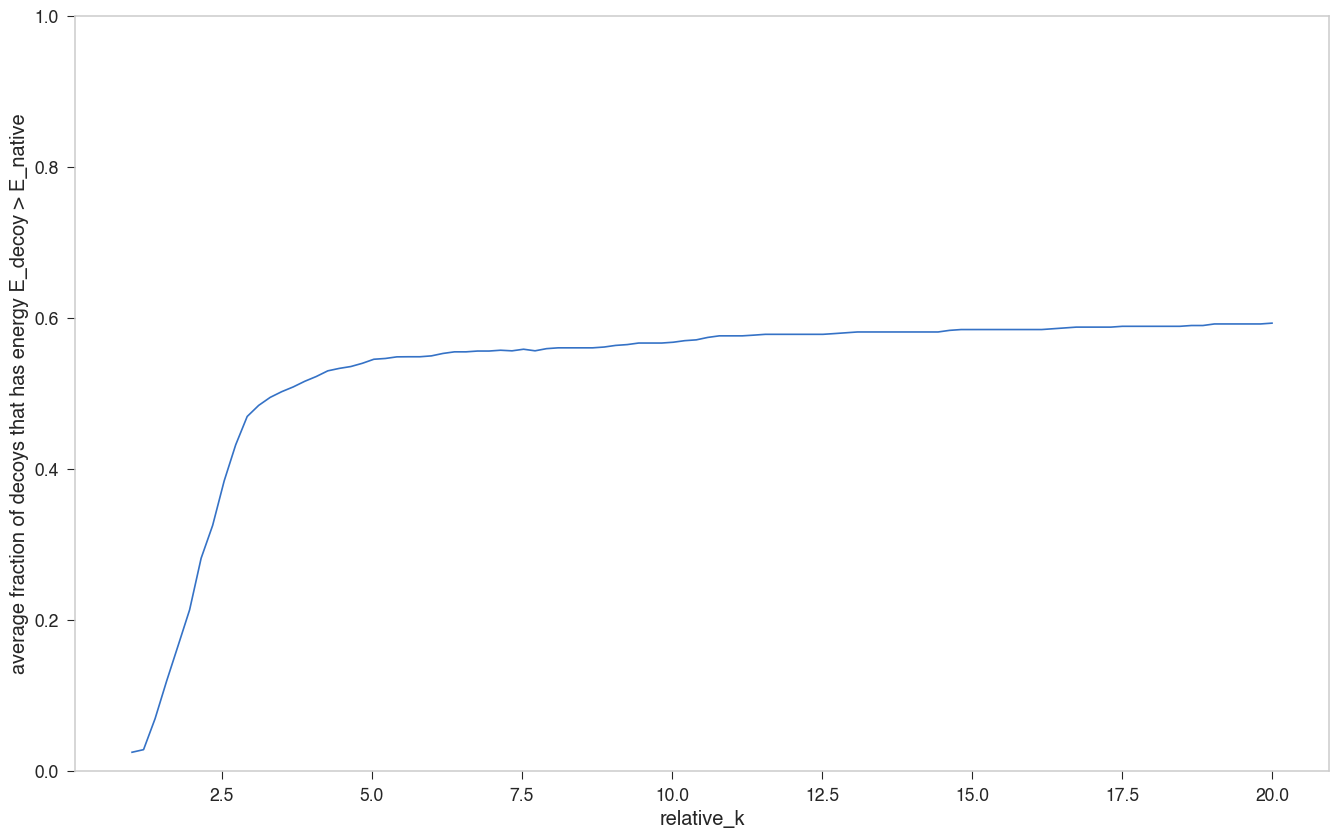

In [166]:
plt.plot(gamma_list, pd.DataFrame(all_value_list).sum(axis=0)/20)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

In [126]:
a.shape

(420, 2)

In [ ]:
np.savetxt()

In [186]:
a = np.loadtxt("/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/optimization/membrane_gamma_original.dat")
b = np.loadtxt("/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/optimization/membrane_gamma_rescaled.dat")


In [171]:
a = np.loadtxt("/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/optimization/membrane_gamma_original.dat")
fileName = "/Users/weilu/Research/server/oct_2019/relative_k_optimization_new_gamma/optimization/membrane_gamma_original_x200.dat"
# a = -a
a *= 200
with open(fileName, "w") as f:
    for i in range(210):
        # f.write(f"{a[i][0]} {a[i][1]}\n")
        f.write(f"{a[i][0]:<.5f} {a[i][1]:10.5f}\n")
    f.write("\n")
    for i in range(210):
        # f.write(f"{a[i][0]} {a[i][1]}\n")
        f.write(f"{a[i+210][0]:<.5f} {a[i+210][1]:10.5f}\n")

(0, 1)

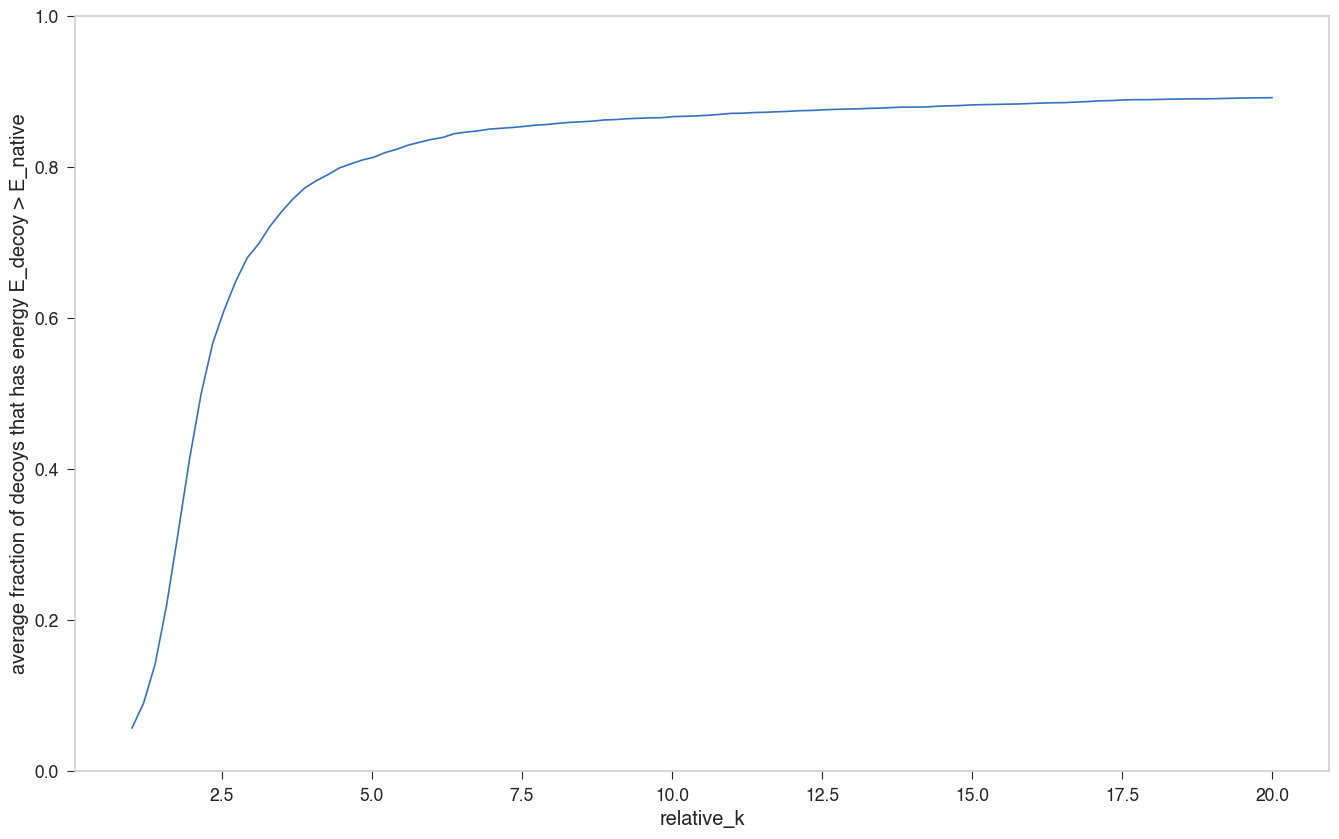

In [122]:
plt.plot(gamma_list, pd.DataFrame(all_value_list).sum(axis=0)/99)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

In [107]:
pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
gamma_list = np.linspace(1,20, num=100)
cutoff = 1.0
all_value_list = []
all_value_sum_list = []
for i, name in enumerate(names):
    cc += 1
    if i % 100 == 0:
        print(i)
        # break
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array(gamma_list, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    all_value_list.append(one_value_list)
    # all_value_sum_list.append(one_value_sum_list)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [112]:
a = pd.DataFrame(all_value_list)

In [115]:
a.to_csv("/Users/weilu/Research/data/relative_k_oct21.csv")

(0, 1)

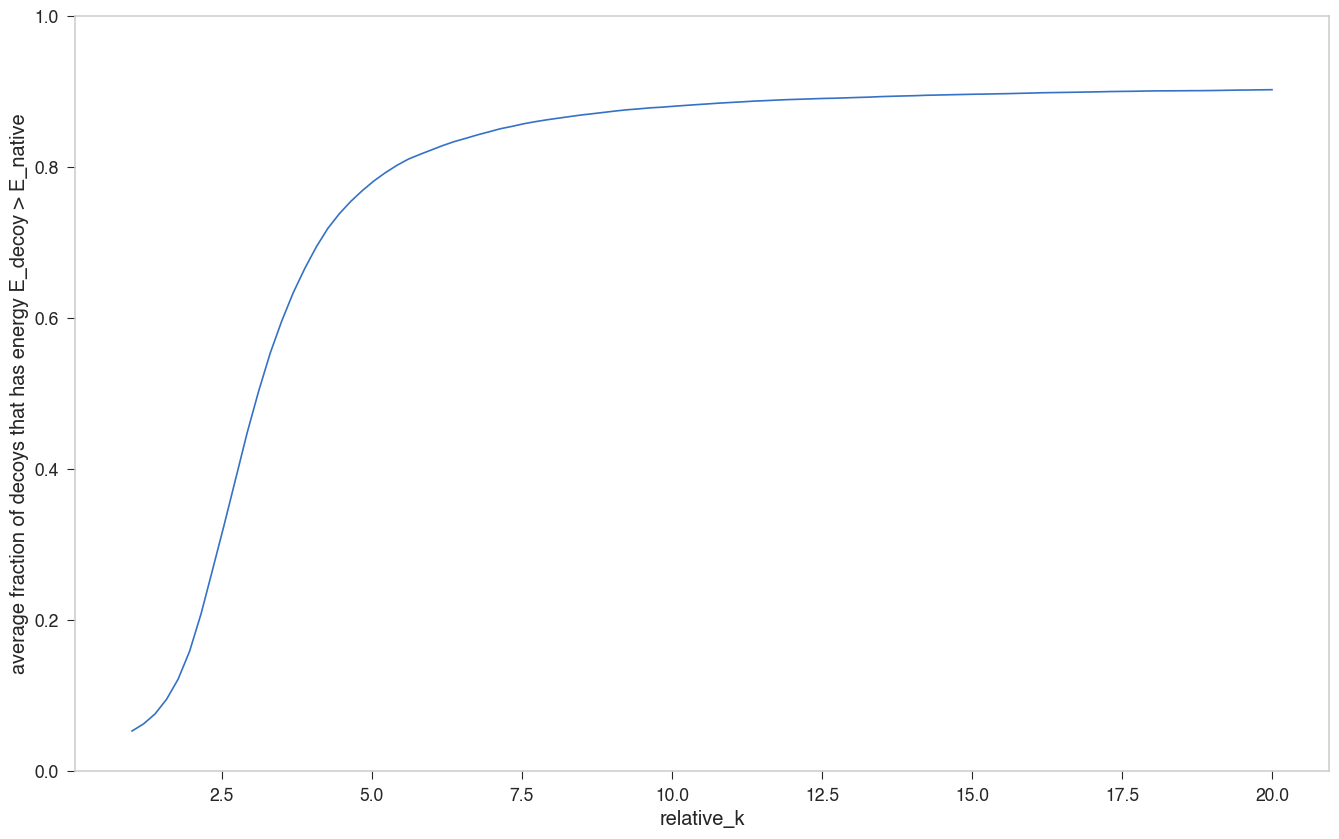

In [110]:
plt.plot(gamma_list, pd.DataFrame(all_value_list).sum(axis=0)/len(names))
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

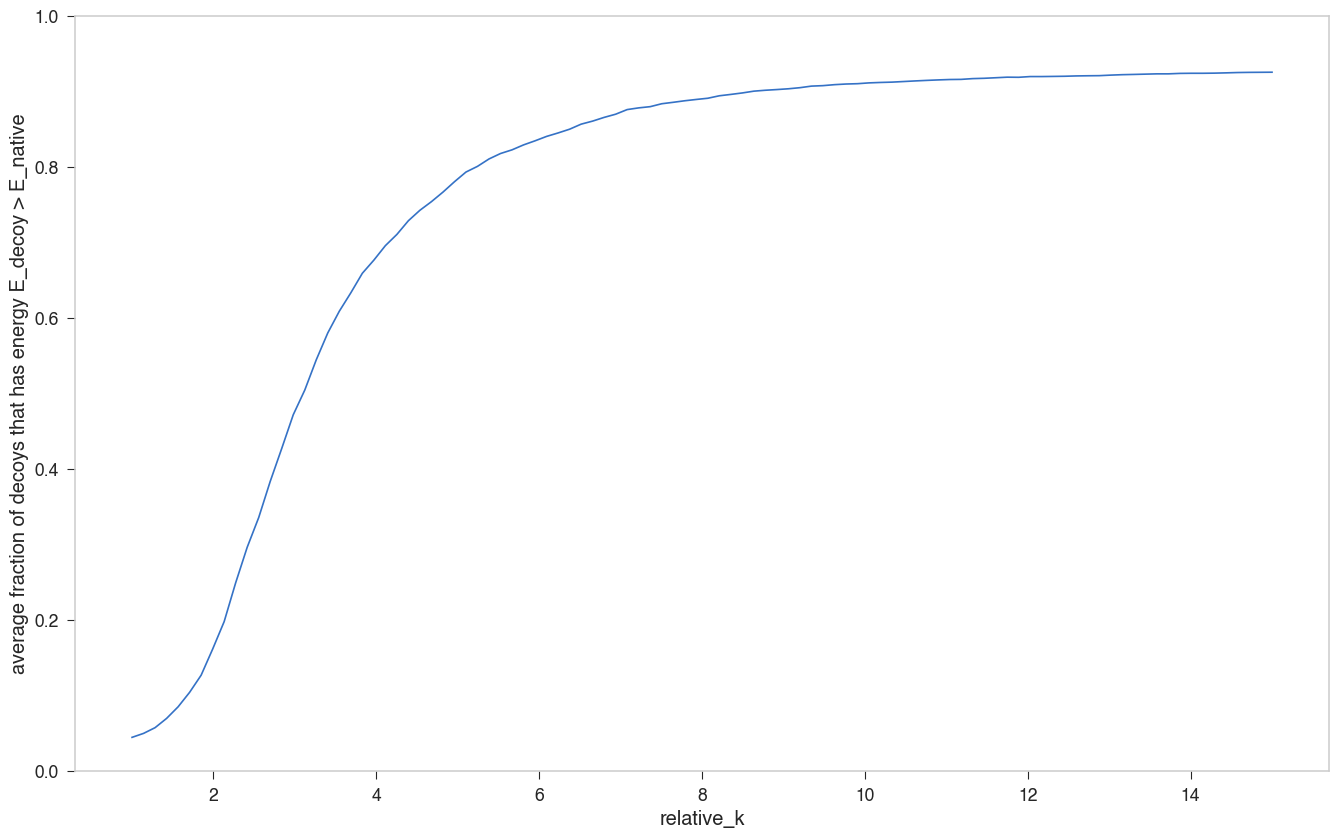

In [106]:
plt.plot(gamma_list, pd.DataFrame(all_value_list).sum(axis=0)/99)
plt.xlabel("relative_k")
plt.ylabel("average fraction of decoys that has energy E_decoy > E_native")
plt.ylim((0,1))
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/relative_k.png", kpi=300)

In [71]:
pre = "/Users/weilu/Research/server/oct_2019/relative_k_optimization/phis"
name = names[0]
cutoff = 1.0
decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
value_list, value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
cc = 0
for i, name in enumerate(names[1:]):
    cc += 1
#     if i % 10 == 0:
#         print(i)
#         break
    if i == 10:
        print(i)
        break
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    value_list += one_value_list
    value_sum_list += one_value_sum_list

# value_list /= len(names)
# one_value_sum_list /= len(names)

10


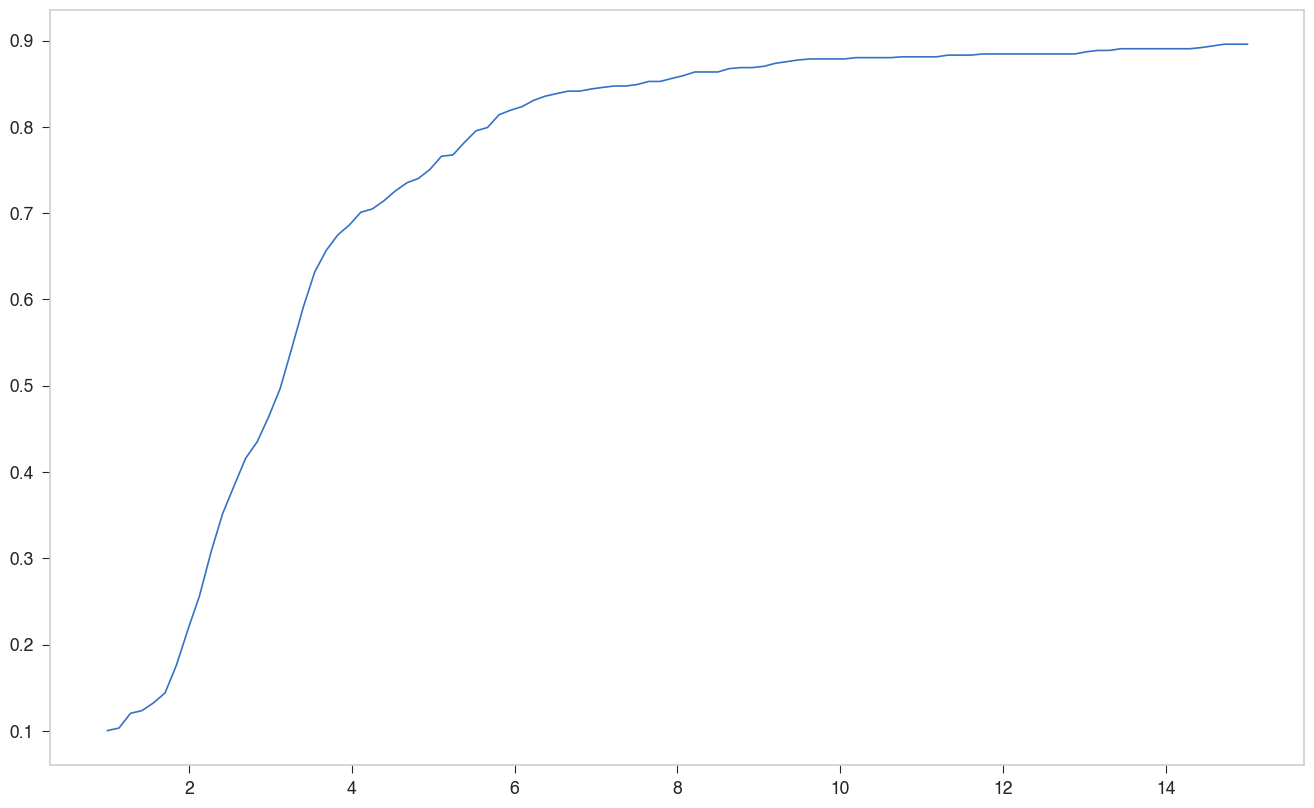

In [73]:
gamma_list = np.linspace(1,15, num=100)
plt.plot(gamma_list, value_list/cc)

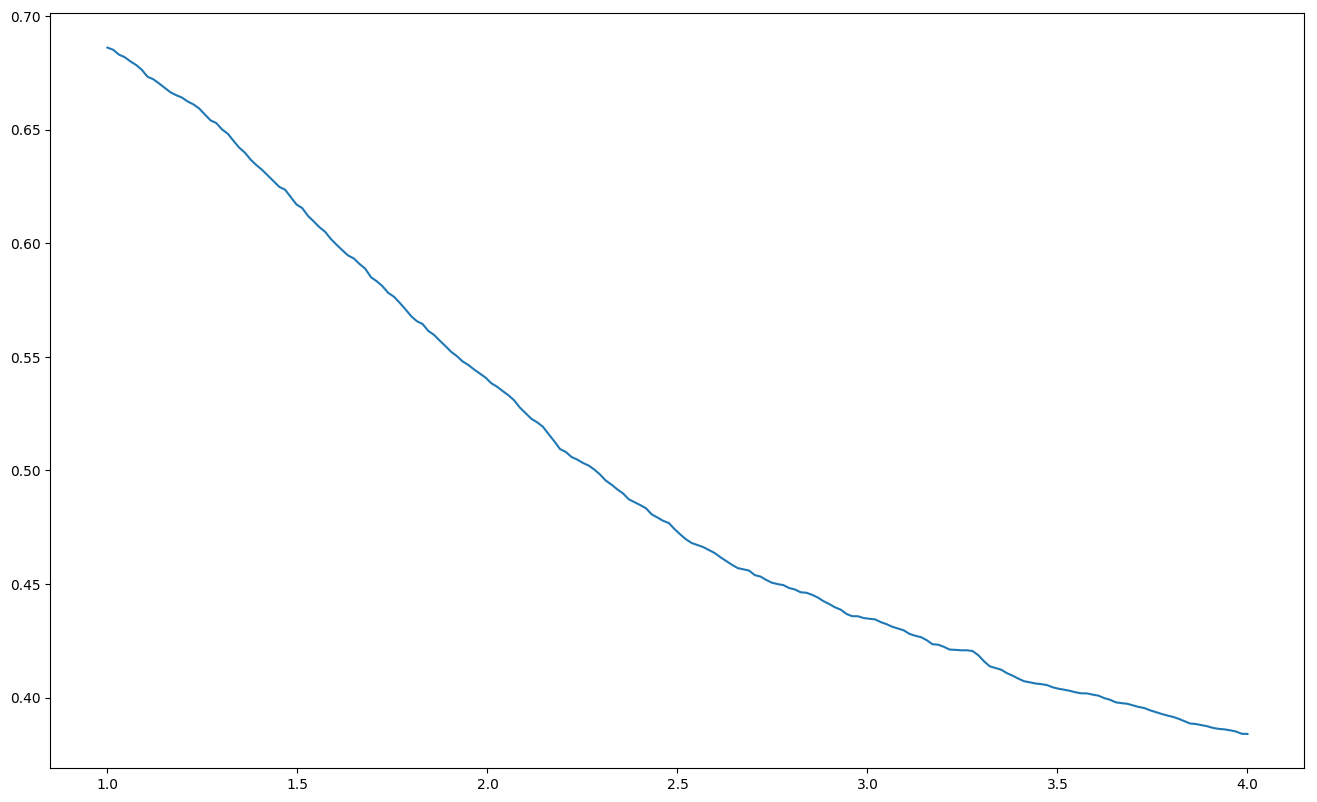

In [180]:
plt.plot(gamma_list, value_list)
# plt.plot(gamma_list, value_sum_list)

In [175]:
pre = "/Users/weilu/Research/server/jun_2019/relative_k/phis"
name = names[0]
cutoff = 0.9
decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
value_list, value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
for i, name in enumerate(names[1:]):
    if i % 100 == 0:
        print(i)
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=cutoff)
    value_list += one_value_list
    value_sum_list += one_value_sum_list

value_list /= len(names)
one_value_sum_list /= len(names)


0
100
200
300
400
500
600
700
800
900
1000
1100


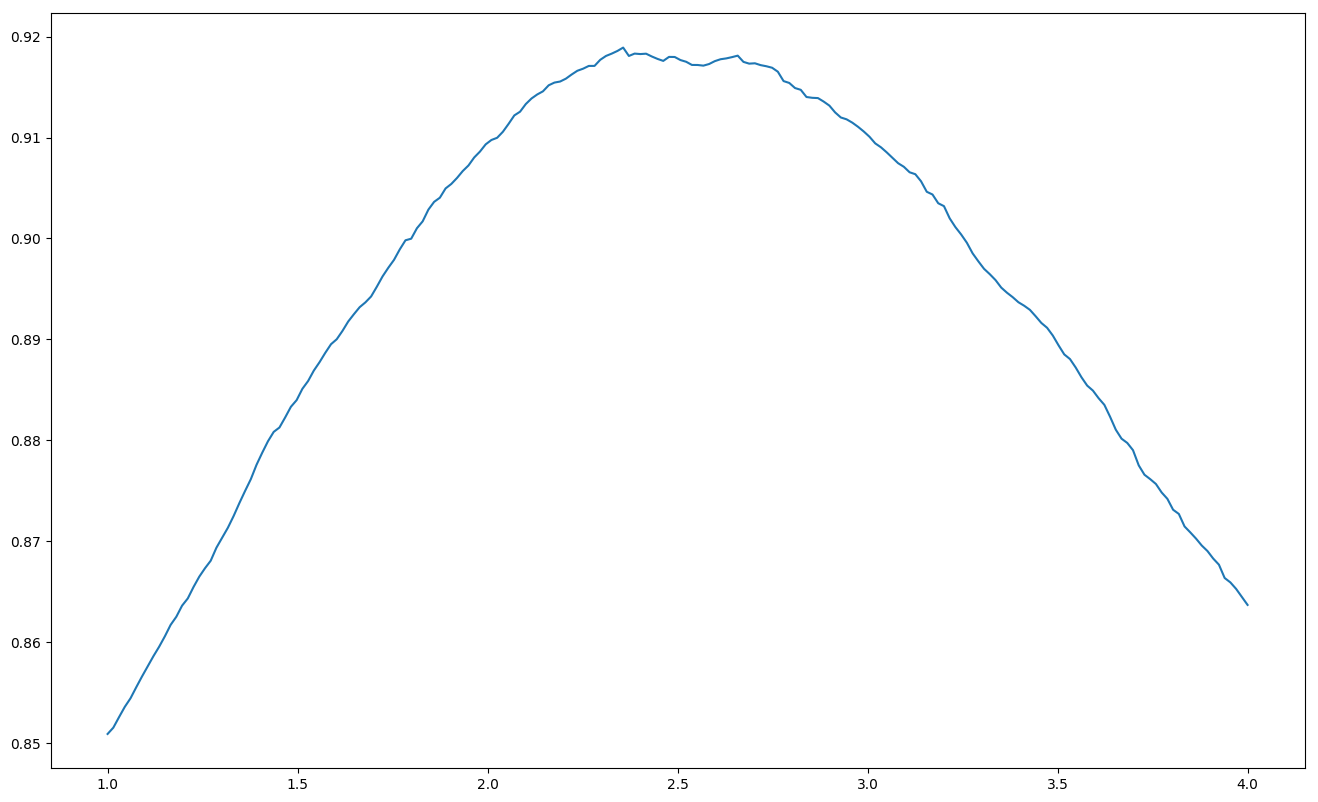

In [178]:
plt.plot(gamma_list, value_list)
# plt.plot(gamma_list, value_sum_list)

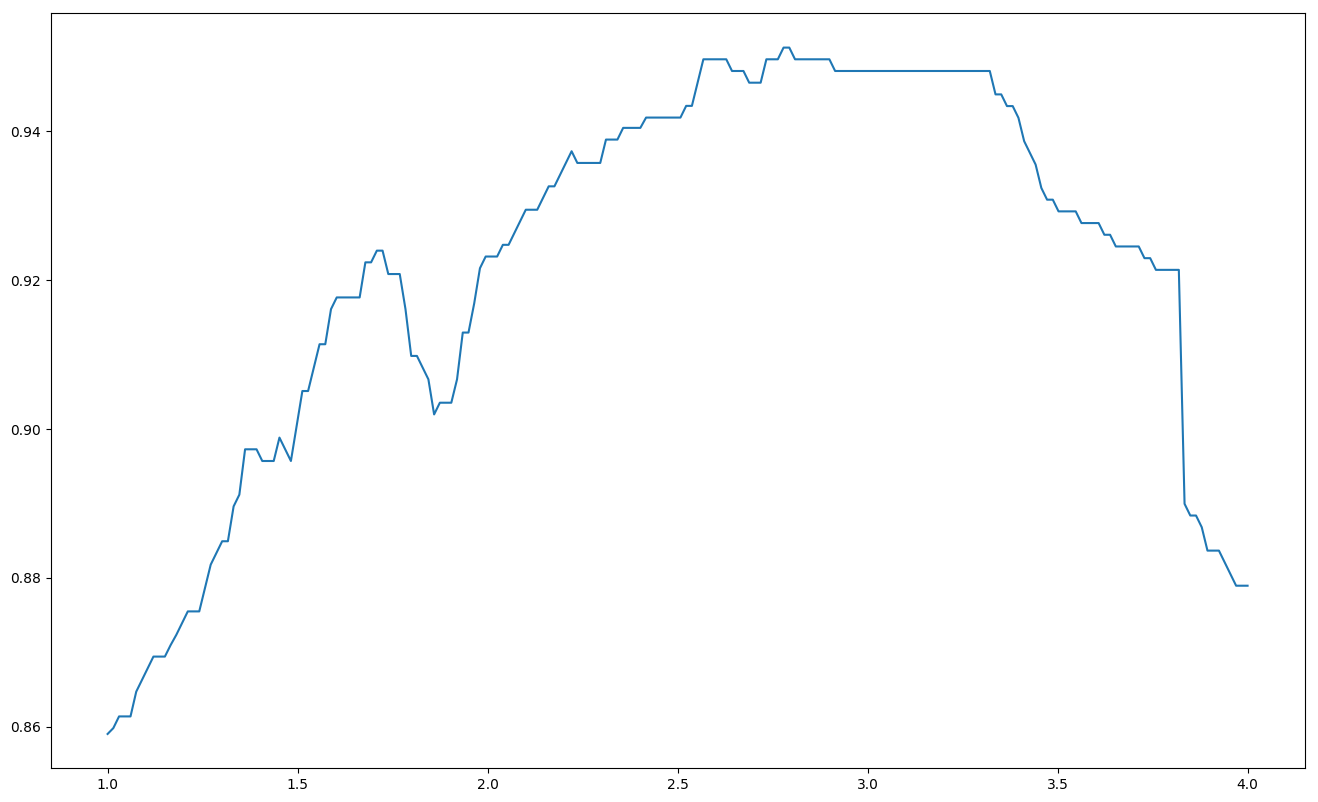

In [170]:
plt.plot(gamma_list, value_list)
# plt.plot(gamma_list, value_sum_list)

In [ ]:
pre = "/Users/weilu/Research/server/jun_2019/relative_k/phis"
decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")



In [163]:
pre = "/Users/weilu/Research/server/jun_2019/relative_k/phis"
name = names[0]
decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
value_list, value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=0.9)
for name in names[1:]:
    decoy = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoys_shifted_4.5_6.5_5.0_10")
    native = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_native_4.5_6.5_5.0_10")
    decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_{name}_decoysQ_shifted_4.5_6.5_5.0_10")
    one_value_list, one_value_sum_list = get_value_array(decoy=decoy, decoyQ=decoyQ, native=native, cutoff=0.9)
    value_list += one_value_list
    value_sum_list += one_value_sum_list

value_list /= len(names)
one_value_sum_list /= len(names)


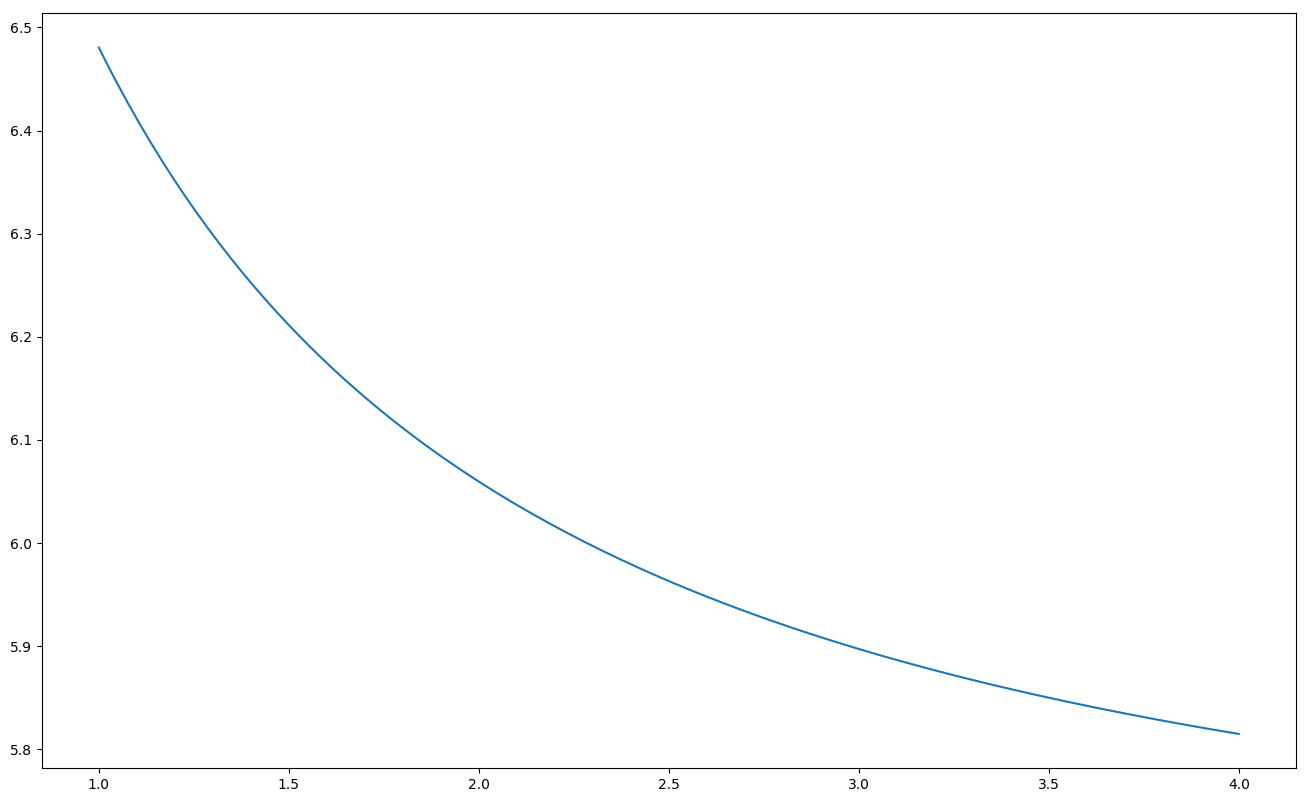

In [166]:
plt.plot(gamma_list, value_sum_list)

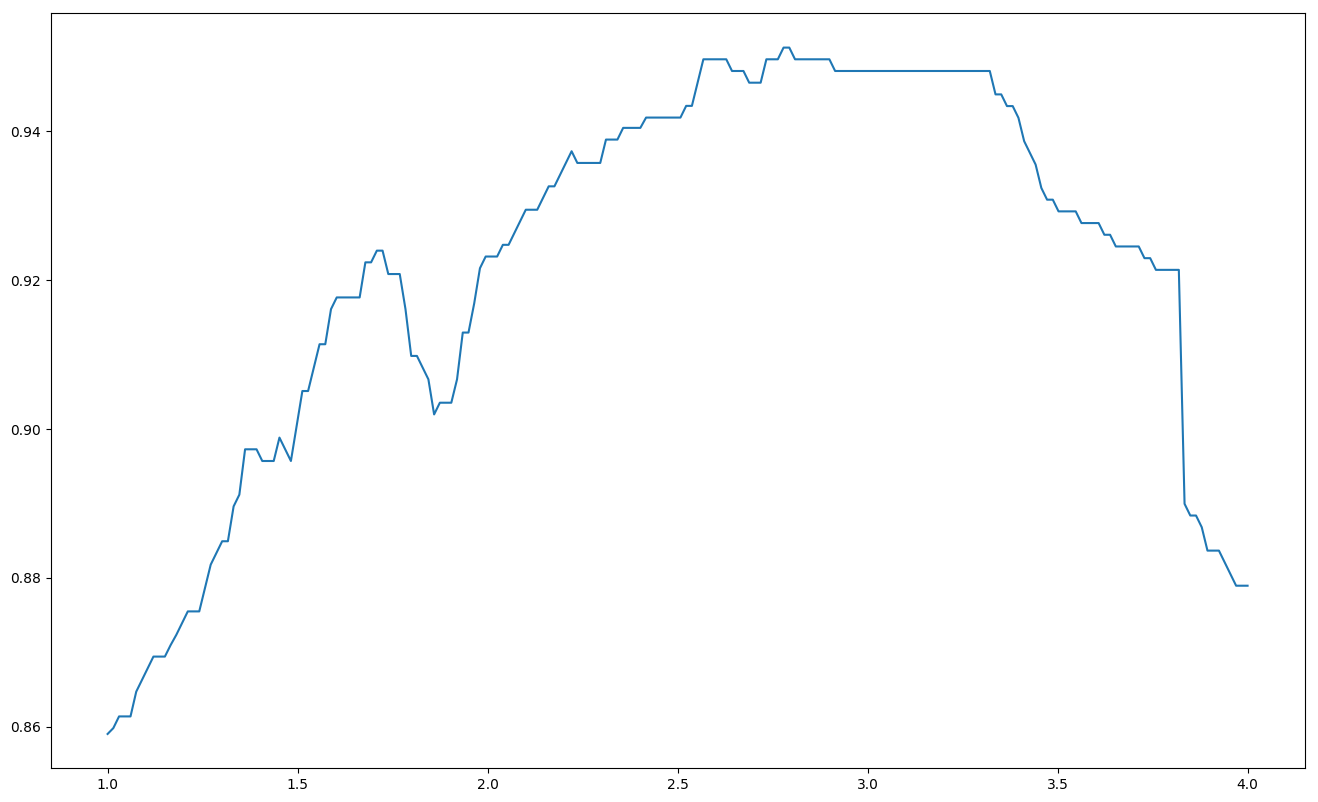

In [165]:
plt.plot(gamma_list, value_list)
# plt.plot(gamma_list, value_sum_list)

In [150]:
value_list, value_sum_list = get_value_array(gamma=gamma, decoy=decoy, decoyQ=decoyQ, native=native, cutoff=0.9)

In [132]:
gamma_list = np.linspace(1,4, num=200)
value_list = []
value_sum_list = []
for gamma in gamma_list:
    value, value_sum = get_value(gamma, decoy, decoyQ, native, cutoff=0.9)
    # print(gamma, value)
    value_list.append(value)
    value_sum_list.append(value_sum)

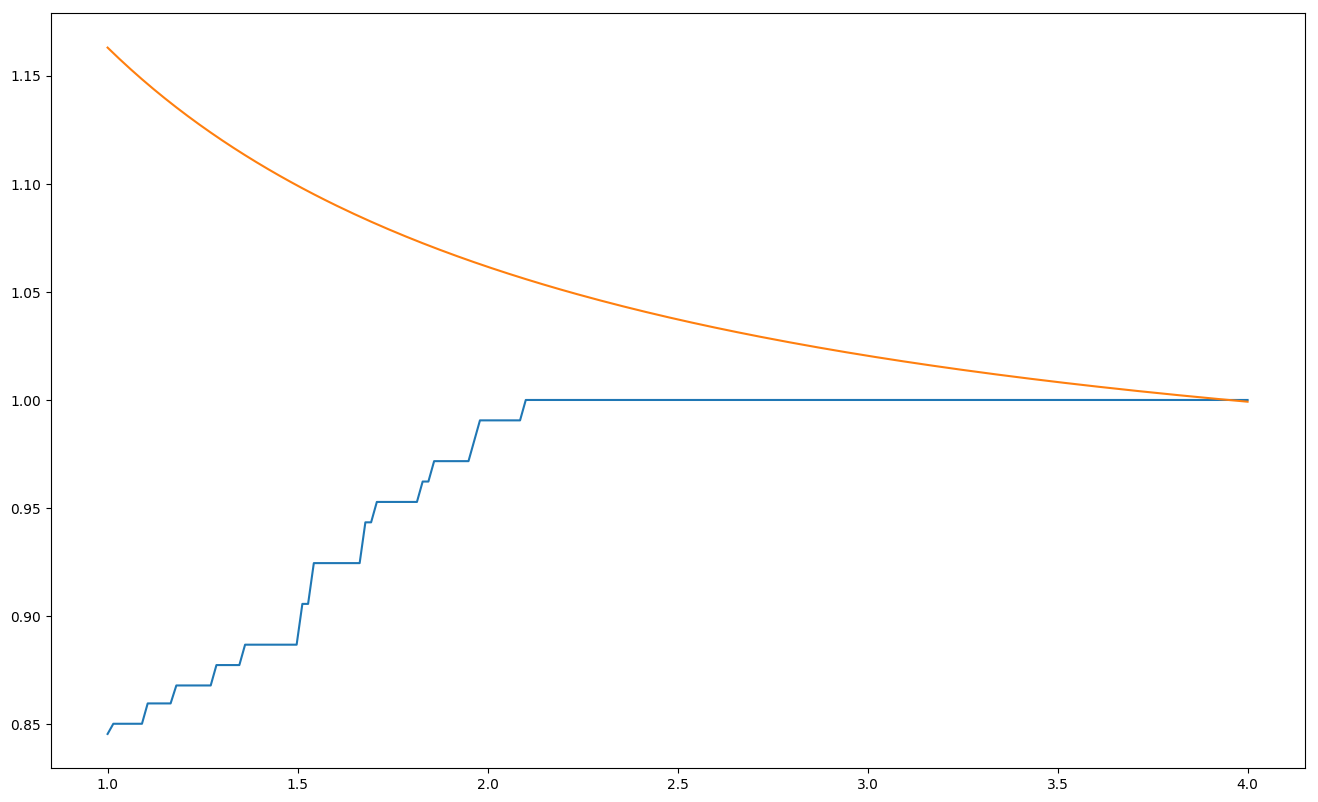

In [133]:
plt.plot(gamma_list, value_list)
plt.plot(gamma_list, value_sum_list)

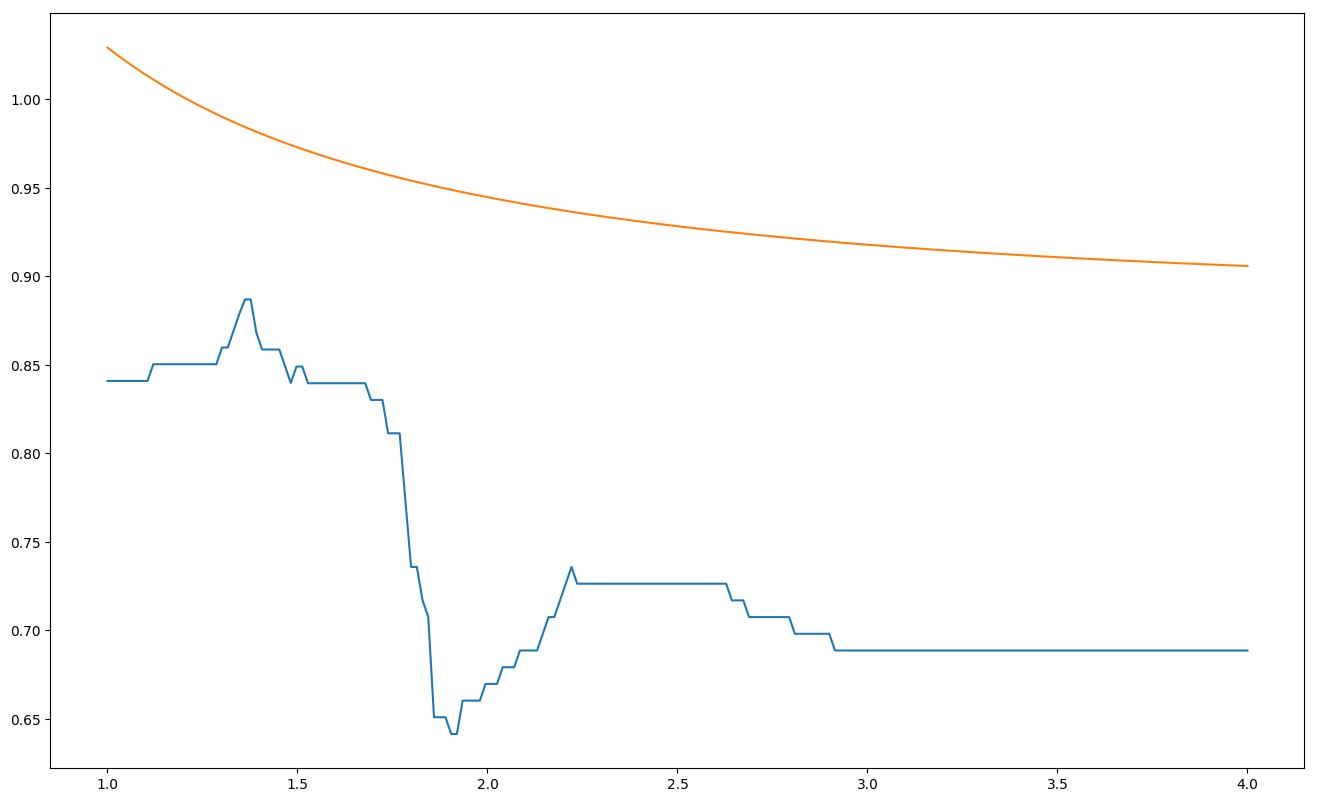

In [128]:
plt.plot(gamma_list, value_list)
plt.plot(gamma_list, value_sum_list)

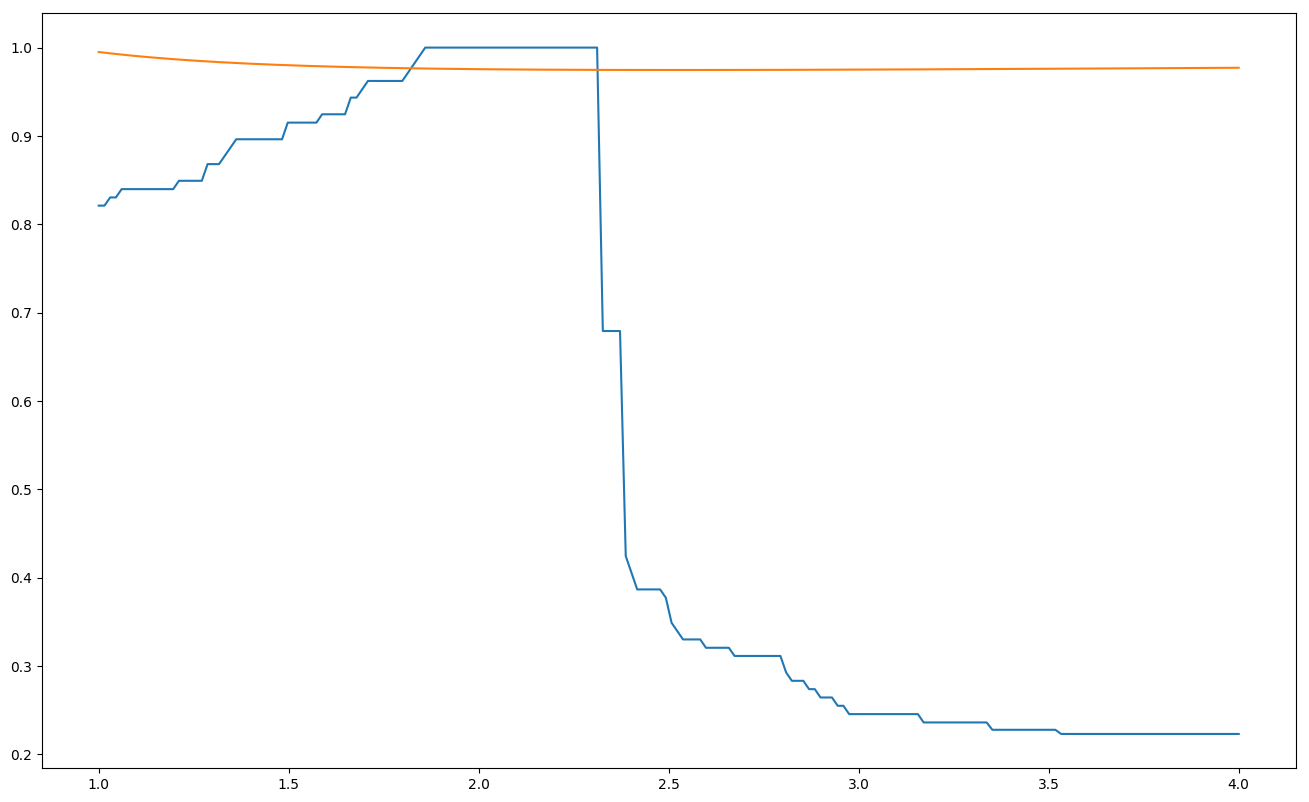

In [82]:
plt.plot(gamma_list, value_list)
plt.plot(gamma_list, value_sum_list)

In [83]:
get_value(2, decoy, decoyQ, native)

(1.0, 0.9755688843602008)

In [117]:
native_energy

221.33339999999998

In [126]:
native_energy/ (2.5 + 128*2 )

0.8562220502901353

0.48108864356347847


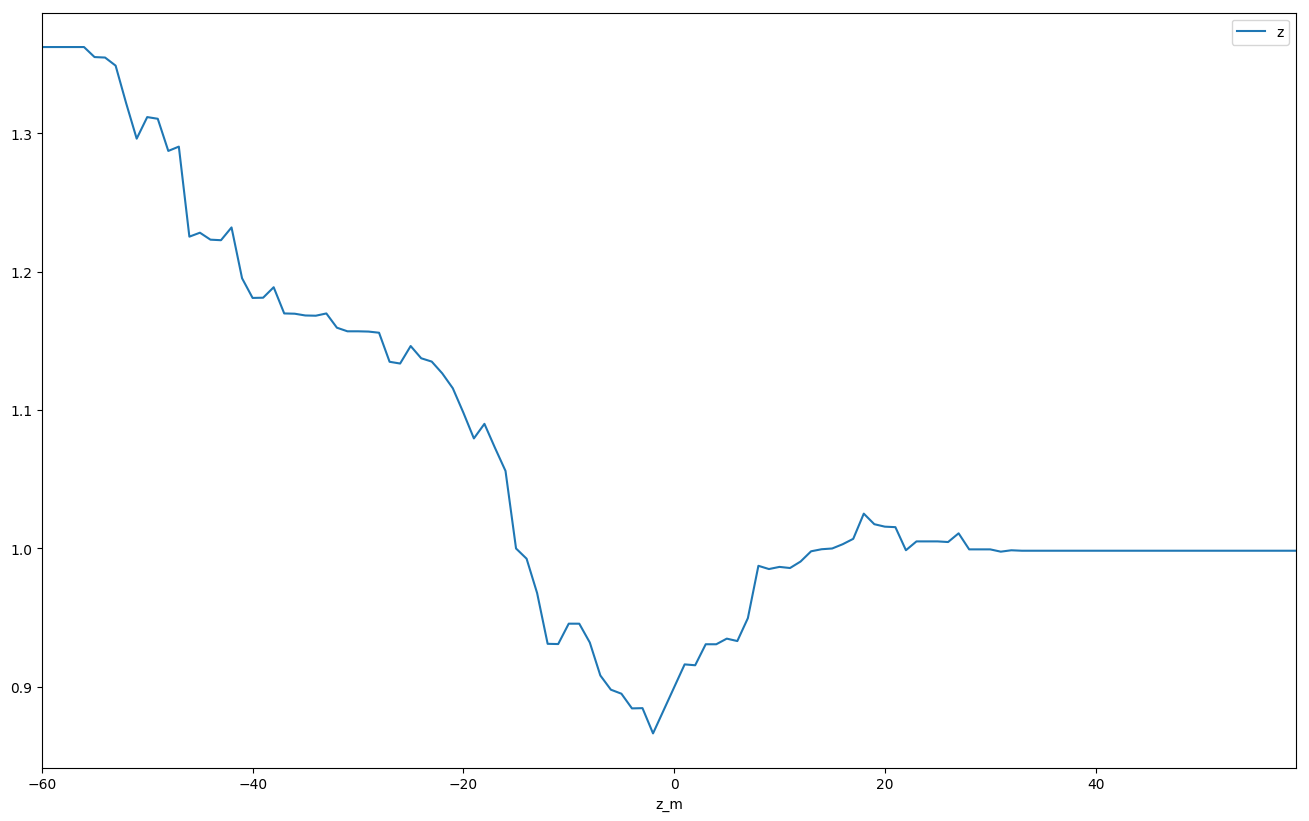

In [144]:
gamma = 1.8
limit =60
cutoff = 1.0
energy = [a[0]+a[1]*gamma for a in decoy]
z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
d.columns = ["z_m", "energy", "Q"]
d = d.sort_values("z_m")
d = d.reset_index()
native_energy =native[0] + native[1]*gamma
d["z"] = native_energy/d["energy"]

value = ( ((d["z"] > cutoff)) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
print(value)
d.plot("z_m", "z")

0.41069983150911604


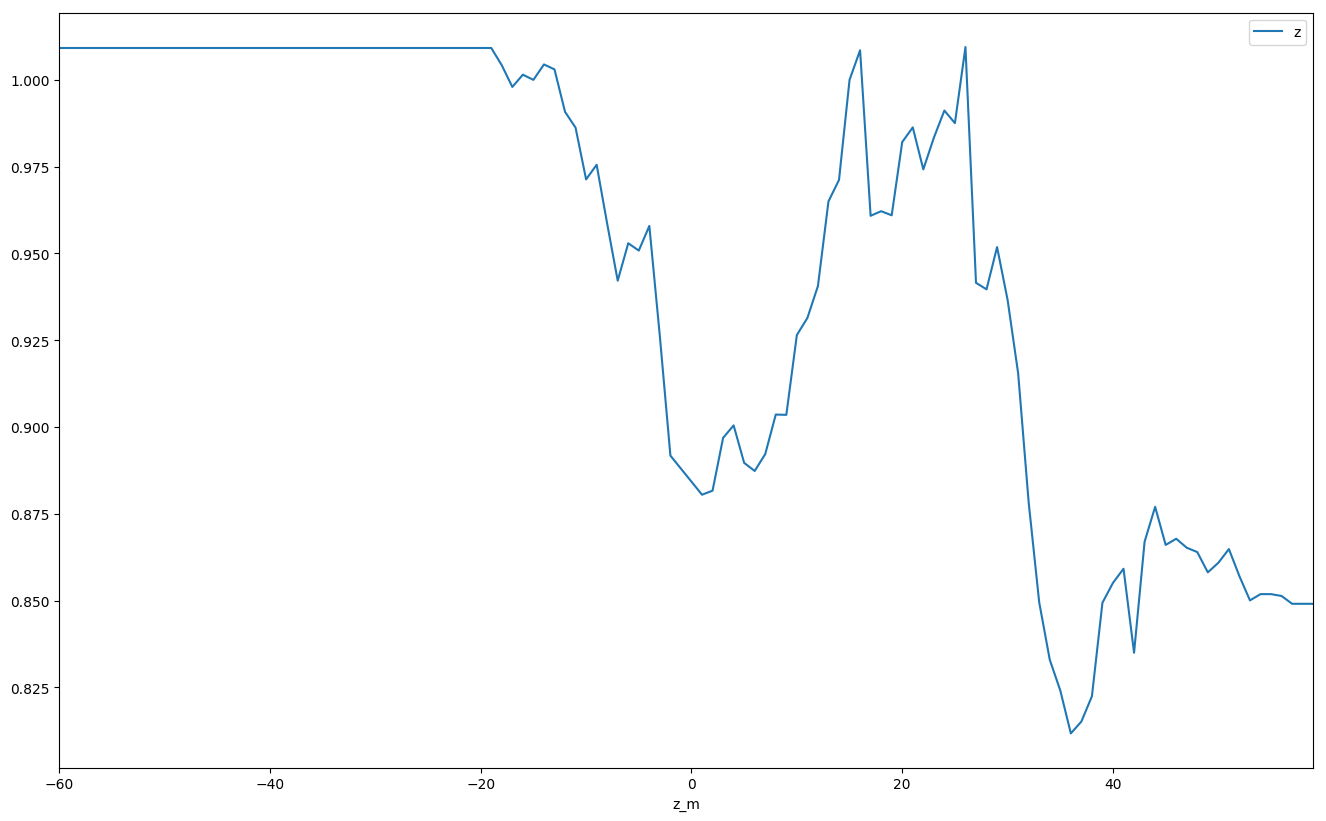

In [111]:
gamma = 2
limit =60
cutoff = 1.0
energy = [a[0]+a[1]*gamma for a in decoy]
z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
d.columns = ["z_m", "energy", "Q"]
d = d.sort_values("z_m")
d = d.reset_index()
native_energy =native[0] + native[1]*gamma
d["z"] = native_energy/d["energy"]

value = ( ((d["z"] > cutoff)) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
print(value)
d.plot("z_m", "z")

In [105]:
d

,index,z_m,energy,Q,z
0,59,-60.0,162.9544,0.0,1.014328
1,60,-59.0,162.9544,0.0,1.014328
2,61,-58.0,162.9544,0.0,1.014328
3,62,-57.0,162.9544,0.0,1.014328
4,63,-56.0,162.9544,0.0,1.014328
5,64,-55.0,162.9544,0.0,1.014328
6,65,-54.0,162.9544,0.0,1.014328
7,66,-53.0,162.9544,0.0,1.014328
8,67,-52.0,162.9544,0.0,1.014328
9,68,-51.0,162.9544,0.0,1.014328


0.1512625495519803


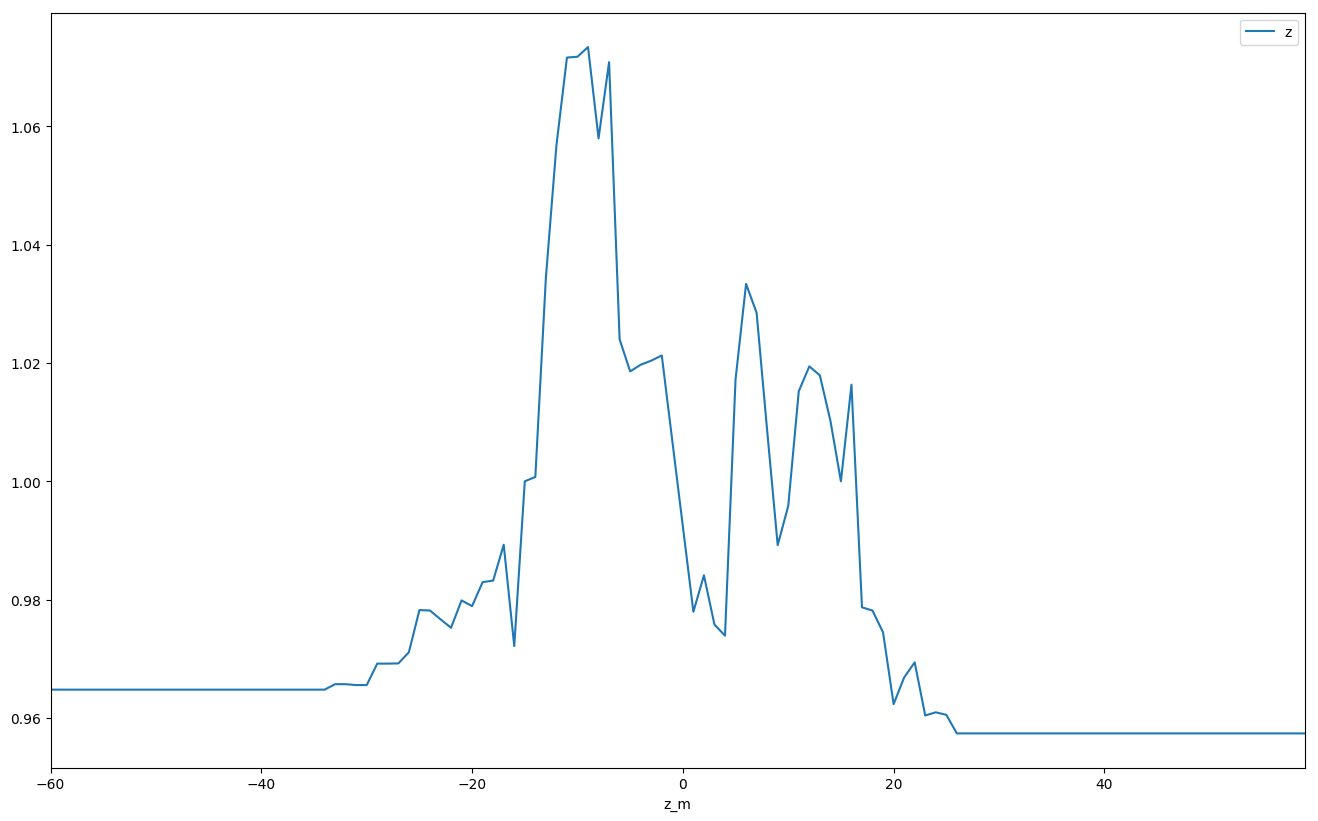

In [84]:
gamma = 2
limit =60
cutoff = 1.0
energy = [a[0]+a[1]*gamma for a in decoy]
z_m =  list(np.arange(1, limit, 1)) + list(np.arange(-limit, -1, 1))
d = pd.DataFrame([z_m, energy, list(decoyQ)]).T
d.columns = ["z_m", "energy", "Q"]
d = d.sort_values("z_m")
native_energy =native[0] + native[1]*gamma
d["z"] = native_energy/d["energy"]

value = ( ((d["z"] > cutoff)) * (1-d["Q"]) ).sum()/(1-d["Q"]).sum()
print(value)
d.plot("z_m", "z")

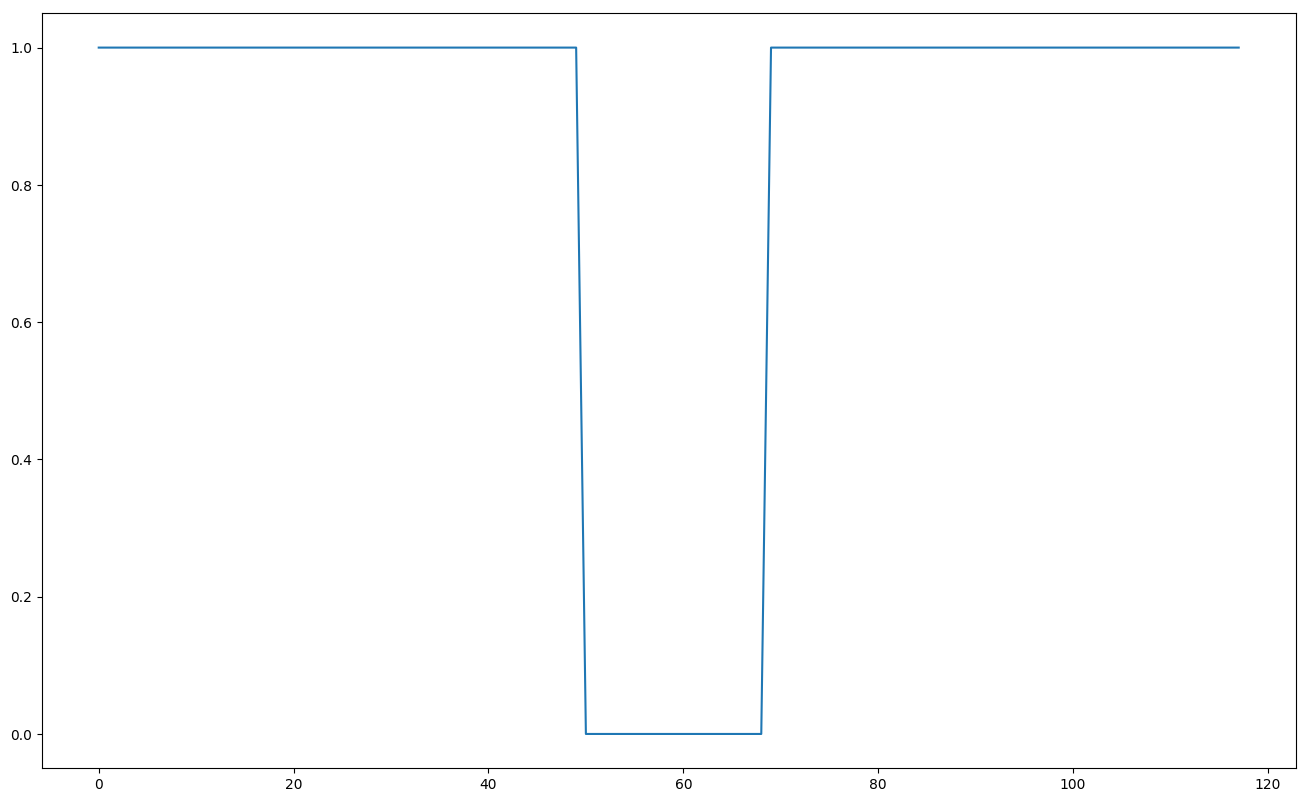

In [47]:
plt.plot( ((d["z"].reset_index()["z"] > 0.95) ) )

In [227]:
d

,z_m,energy,z
59,-60.0,687.9749,0.964768
60,-59.0,687.9749,0.964768
61,-58.0,687.9749,0.964768
62,-57.0,687.9749,0.964768
63,-56.0,687.9749,0.964768
64,-55.0,687.9749,0.964768
65,-54.0,687.9749,0.964768
66,-53.0,687.9749,0.964768
67,-52.0,687.9749,0.964768
68,-51.0,687.9749,0.964768


In [192]:
decoys_all = np.loadtxt("/Users/weilu/Research/server/jun_2019/relative_k/phis/protein_list_phi_relative_k_well4.5_6.5_5.0_10_phi_decoy_all_summary.txt")
decoy_Q = np.loadtxt("/Users/weilu/Research/server/jun_2019/relative_k/phis/phi_relative_k_well_5j4i_decoysQ_shifted_4.5_6.5_5.0_10")


In [197]:
normalized = decoys_all.sum(axis=0) / (1-decoy_Q).sum()

In [198]:
normalized

array([ 89.09506801, 295.90188123])

In [183]:
(1-decoy_Q).sum()

105.9998

In [174]:
decoys_all.mean(axis=0)

array([ 80.03440161, 265.80966297])

In [ ]:
pre = "/Users/weilu/Research/server/jun_2019/relative_k/phis"
decoy_high = np.loadtxt(f"{pre}/{name}_phis_high")
decoy_low = np.loadtxt(f"{pre}/{name}_phis_low")



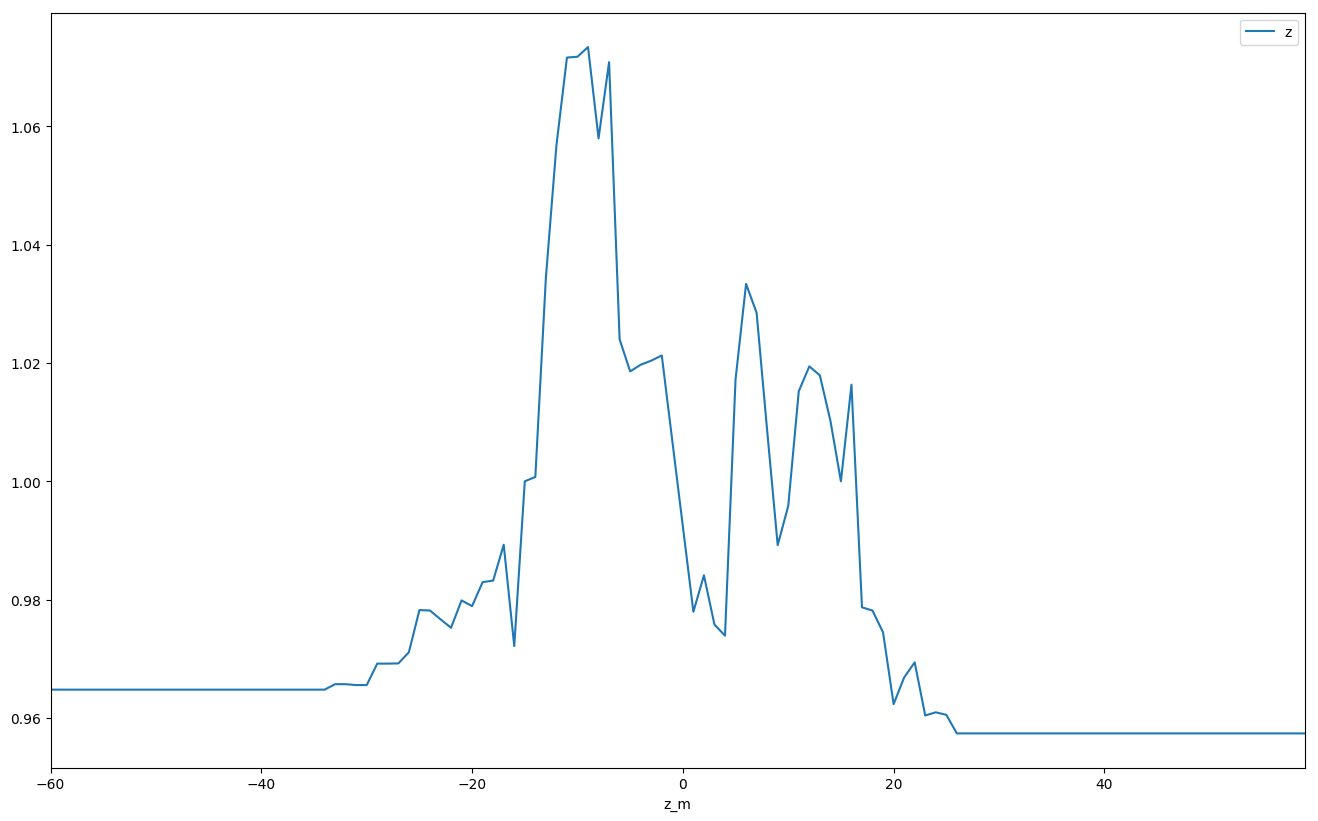

In [220]:
gamma = 2
energy = [a[0]+a[1]*gamma for a in decoy_low]
z_m =  list(z_m_high) + list(z_m_low)
d = pd.DataFrame([z_m, energy]).T
d.columns = ["z_m", "energy"]
d = d.sort_values("z_m")
native_energy = d.query("abs(z_m) == 15").iloc[0][1]
d["z"] = native_energy/d["energy"]
d.plot("z_m", "z")

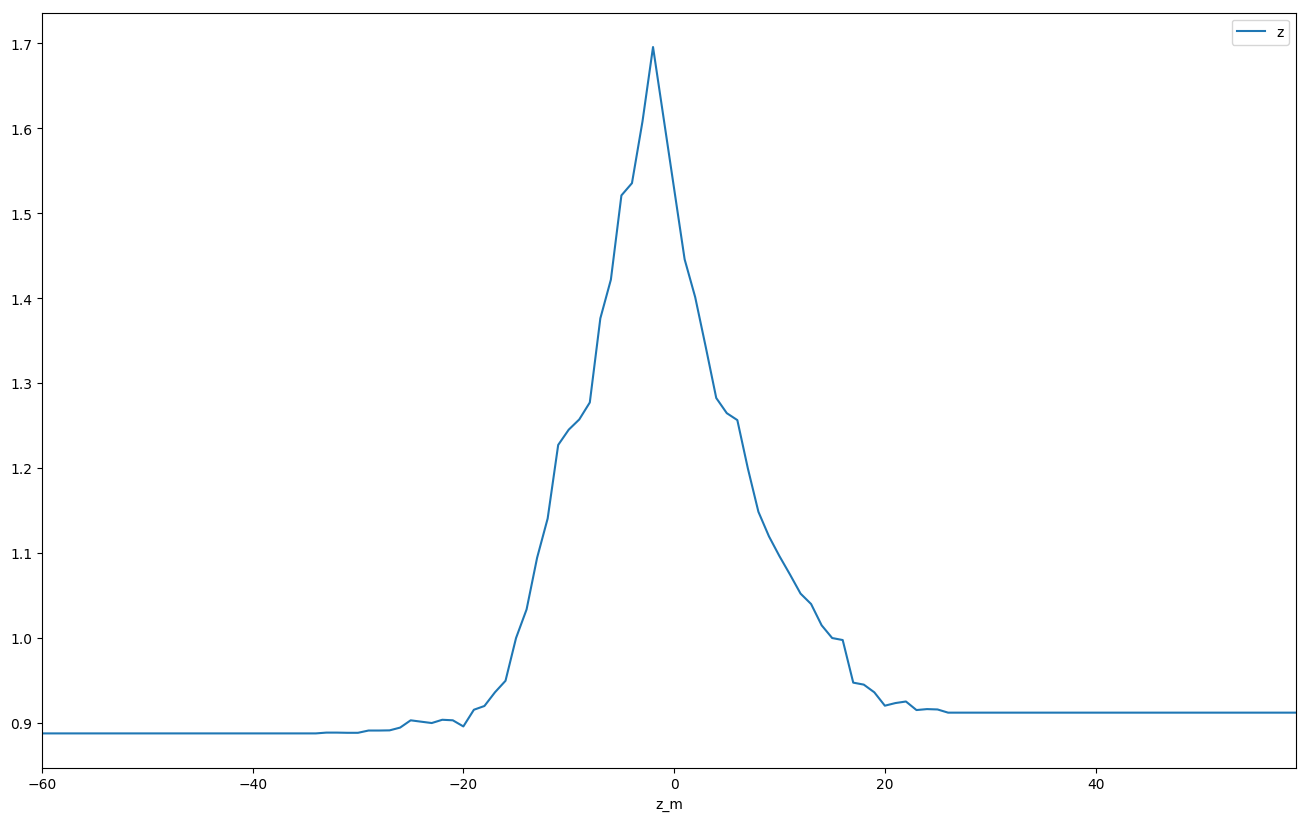

In [216]:
gamma = 10
energy = [a[0]+a[1]*gamma for a in decoy_low]
z_m =  list(z_m_high) + list(z_m_low)
d = pd.DataFrame([z_m, energy]).T
d.columns = ["z_m", "energy"]
d = d.sort_values("z_m")
native_energy = d.query("abs(z_m) == 15").iloc[0][1]
d["z"] = native_energy/d["energy"]
d.plot("z_m", "z")

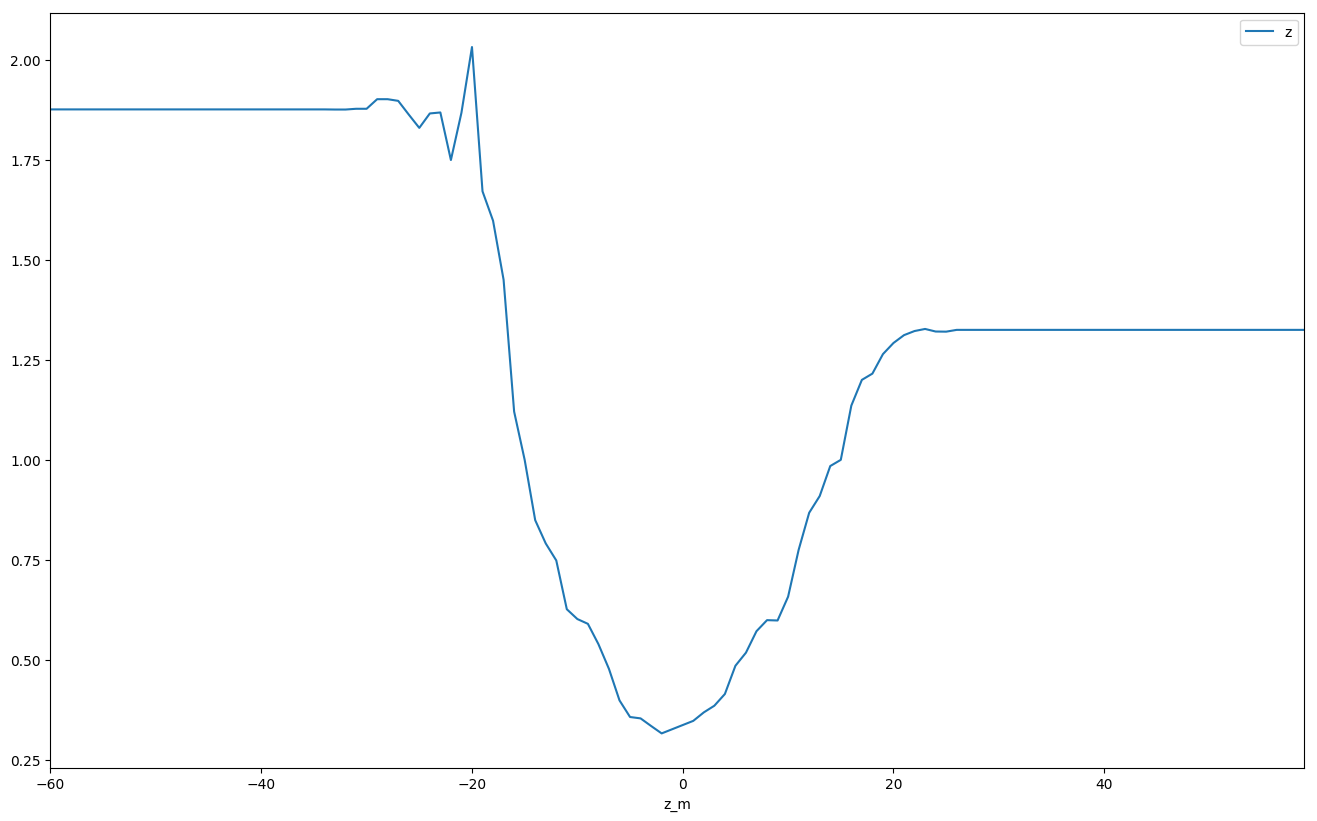

In [212]:
gamma = 0.1
energy = [a[0]+a[1]*gamma for a in decoy_low]
z_m =  list(z_m_high) + list(z_m_low)
d = pd.DataFrame([z_m, energy]).T
d.columns = ["z_m", "energy"]
d = d.sort_values("z_m")
native_energy = d.query("abs(z_m) == 15").iloc[0][1]
d["z"] = native_energy/d["energy"]
d.plot("z_m", "z")

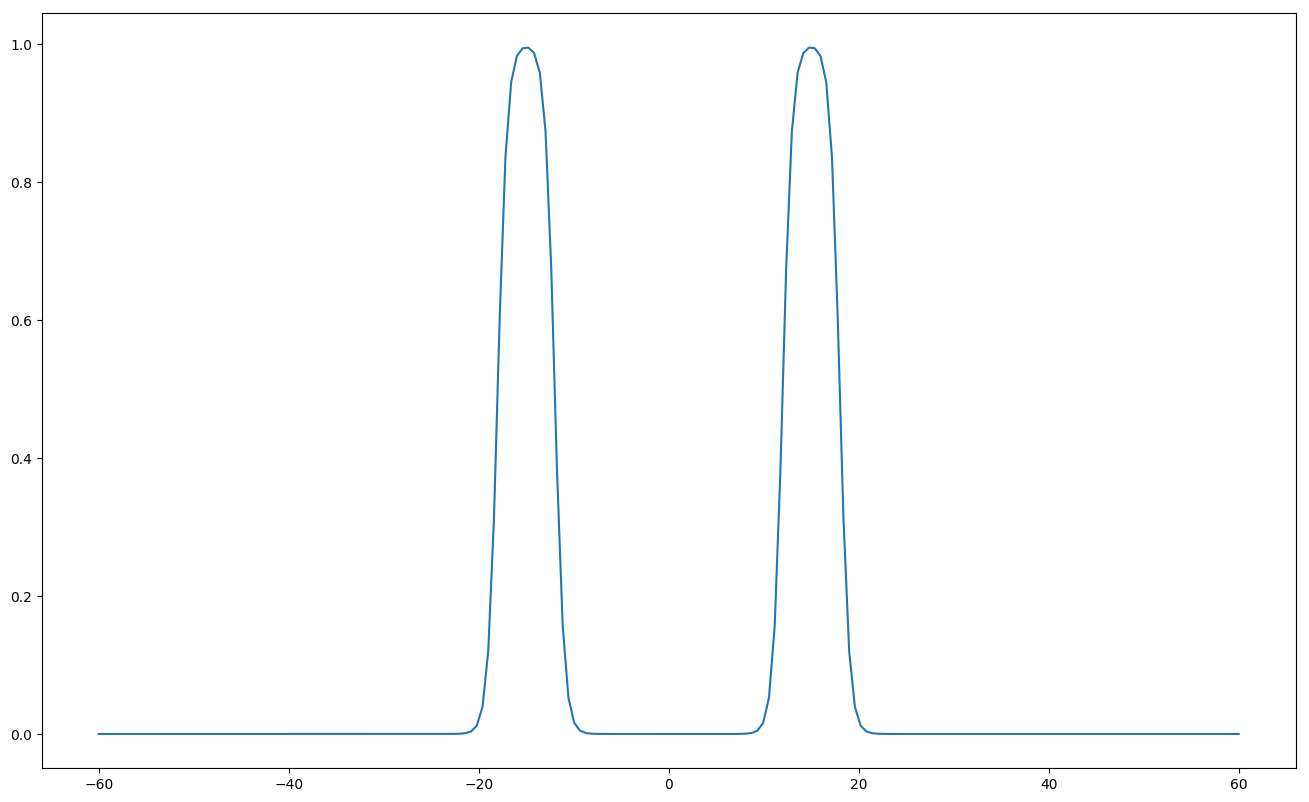

In [169]:
def interaction_well(r, r_min, r_max, kappa):
    return 0.5 * (np.tanh(kappa * (r - r_min)) * np.tanh(kappa * (r_max - r))) + 0.5
# r = np.linspace(10, 20, num=200)
r = np.linspace(-60,60, num=200)
y = interaction_well(r, 12, 18, 1) + interaction_well(r, -18, -12, 1)
plt.plot(r, y)

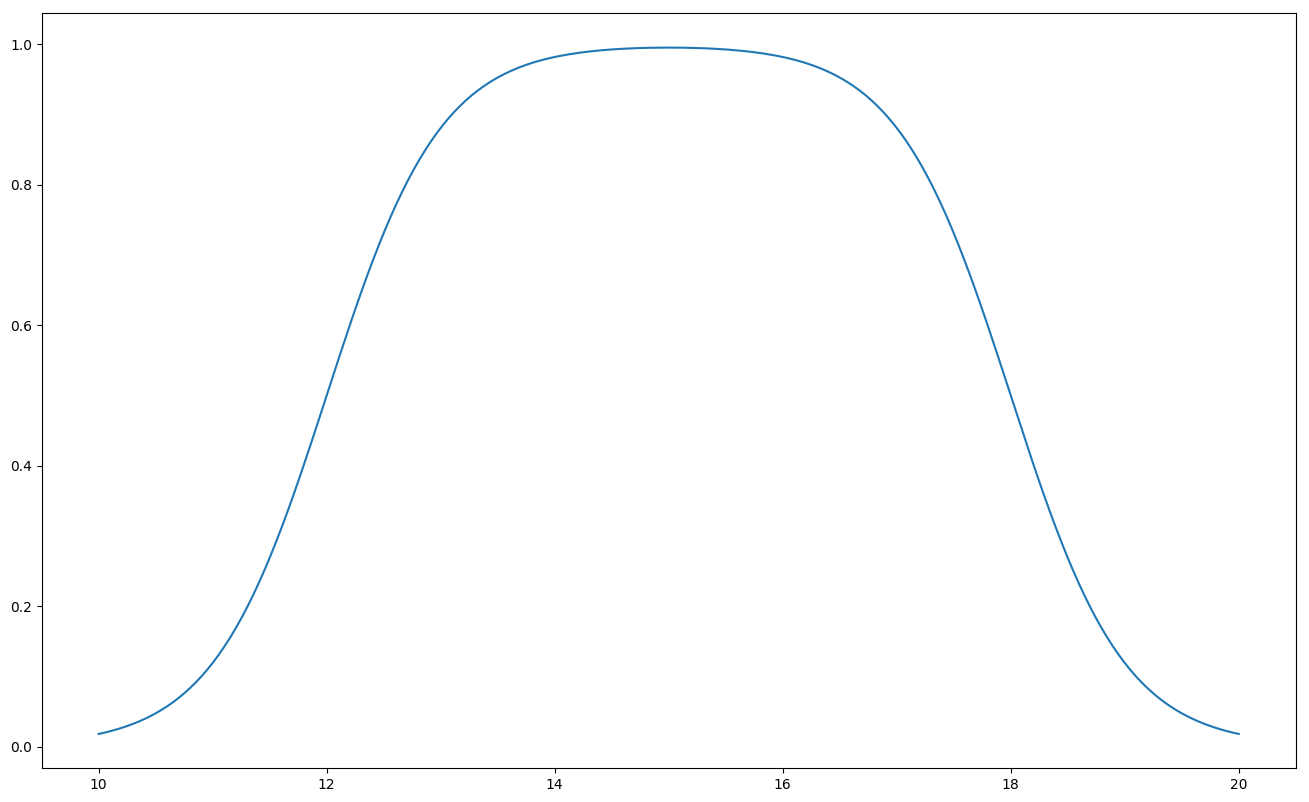

In [167]:
r = np.linspace(10, 20, num=200)
y = interaction_well(r, 12, 18, 1)
plt.plot(r, y)

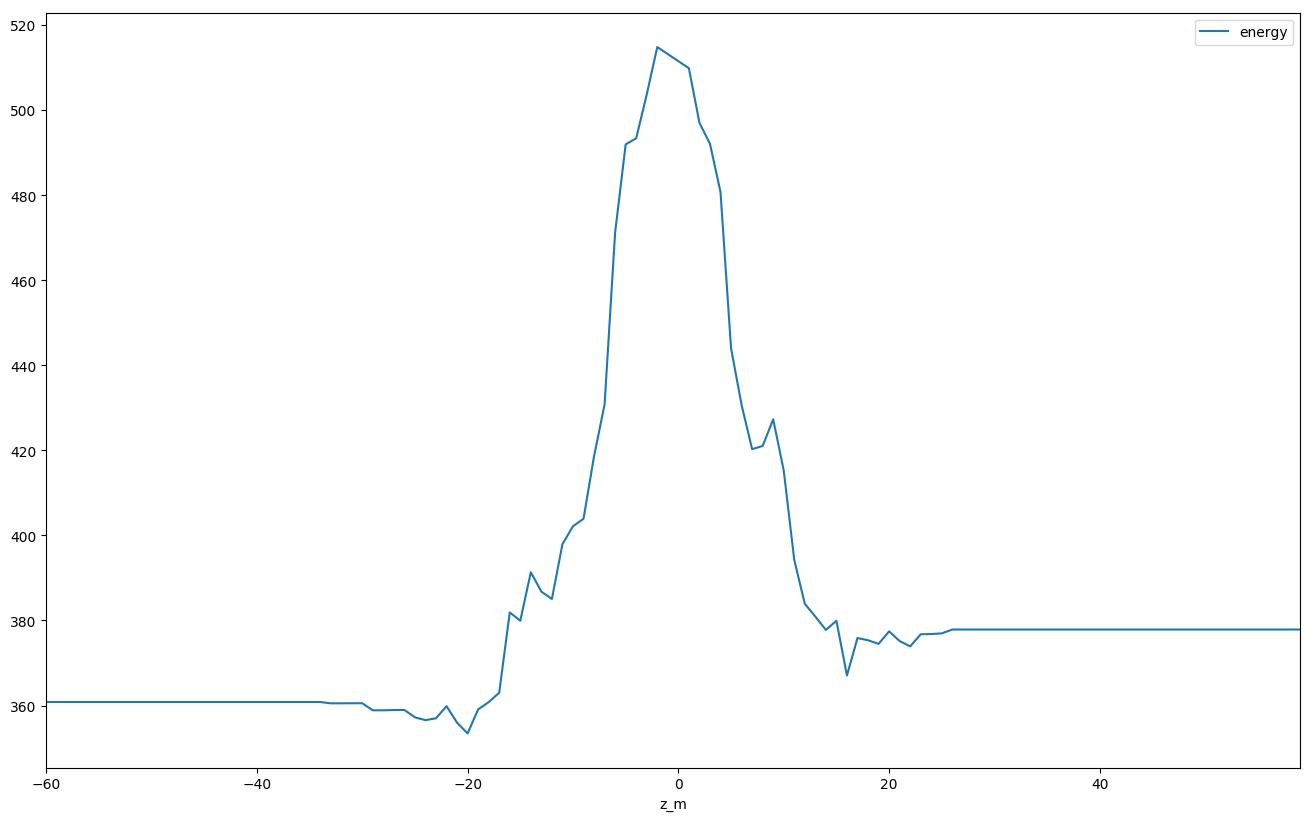

In [134]:
d.plot("z_m", "energy")

In [122]:
len(energy)

118

In [46]:
pre = "/Users/weilu/Research/server/jun_2019/relative_k/phis"
decoy = np.loadtxt(f"{pre}/phi_relative_k_well_5j4i_decoys_shifted_4.5_6.5_5.0_10")
native = np.loadtxt(f"{pre}/phi_relative_k_well_5j4i_native_4.5_6.5_5.0_10")
decoyQ = np.loadtxt(f"{pre}/phi_relative_k_well_5j4i_decoysQ_shifted_4.5_6.5_5.0_10")



In [54]:
def compute_energy(decoy, native, decoyQ, gamma):
    energy = [a[0]+a[1]*gamma for a in decoy]
    return np.array(energy)

In [70]:
gamma = 10
native_energy = native[0] + native[1]*gamma

In [71]:
decoy_energy = compute_energy(decoy, native, decoyQ, gamma)



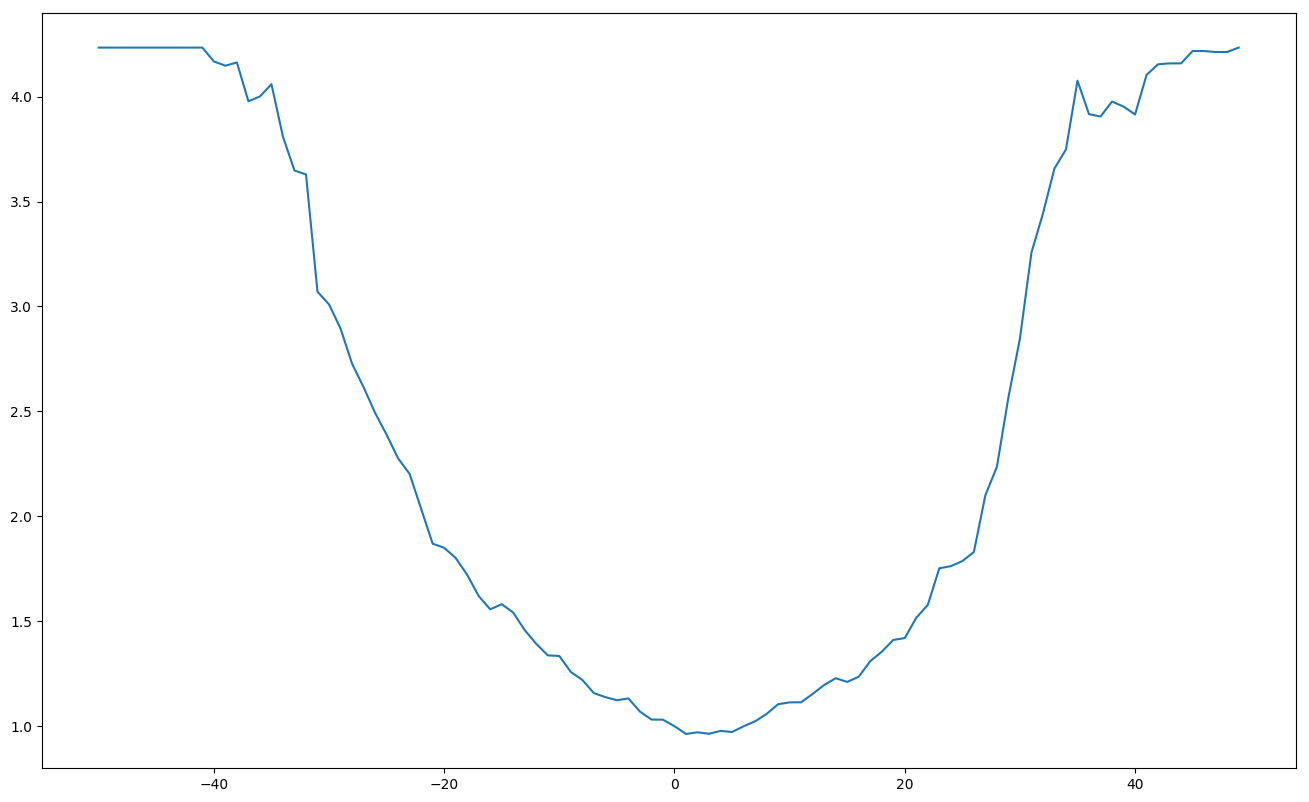

In [72]:
offset_all = np.arange(-50, 50, 1)
z = native_energy/decoy_energy
plt.plot(offset_all, z)

In [45]:
decoyQ

array([0.37528604, 0.37528604, 0.37528604, 0.37528604, 0.37528604,
       0.37528604, 0.37528604, 0.37528604, 0.37528604, 0.37299771,
       0.37185355, 0.36498856, 0.35697941, 0.34668192, 0.33524027,
       0.31922197, 0.29977117, 0.27803204, 0.25858124, 0.23913043,
       0.21395881, 0.23226545, 0.24828375, 0.27116705, 0.28832952,
       0.30778032, 0.33409611, 0.35469108, 0.37871854, 0.39702517,
       0.41533181, 0.43592677, 0.46224256, 0.48283753, 0.49885584,
       0.51716247, 0.5389016 , 0.55377574, 0.58009153, 0.60183066,
       0.62356979, 0.64988558, 0.67963387, 0.70823799, 0.74485126,
       0.78489703, 0.81922197, 0.86613272, 0.8993135 , 0.95308924,
       1.        , 0.95652174, 0.92334096, 0.87757437, 0.83524027,
       0.79290618, 0.74485126, 0.70709382, 0.66132723, 0.63501144,
       0.60526316, 0.5778032 , 0.54576659, 0.52402746, 0.50800915,
       0.48855835, 0.46338673, 0.44622426, 0.41990847, 0.40045767,
       0.3798627 , 0.3604119 , 0.33867277, 0.32036613, 0.29519

In [3]:
data = pd.read_csv("/Users/weilu/Research/database/membrane_training_set/proteins-2019-05-01.csv")
data.pdbid = data.pdbid.apply(lambda x: x[2:-1])

In [4]:
data.head()

,id,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,...,species_id,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at
0,1,2024.0,OmpA family,Escherichia coli,Gram-neg. outer,"Outer membrane protein A (OMPA), disordered loops",NaN,OmpA is required for the action of colicins K ...,1qjp,1.65,...,9,34,26,2,1,3,1,2,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
1,2,2028.0,Enterobacterial Ail/Lom protein,Escherichia coli,Gram-neg. outer,Outer membrane protein X (OMPX),NaN,OmpX from Escherichia coli promotes adhesion t...,1qj8,1.90,...,9,355,26,2,1,7,1,1,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
2,3,2033.0,Opacity porins,Neisseria meningitidis,Gram-neg. outer,Outer membrane protein NspA,NaN,Pathogenic Neisseria spp. possess a repertoire...,1p4t,2.55,...,24,337,235,2,1,0,1,0,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
3,4,1740.0,Influenza virus matrix protein 2,Influenza virus,Viral,"M2 proton channel of Influenza A, closed state...",NaN,NaN,3lbw,1.65,...,51,263,185,11,1,3,4,0,2018-08-13 03:49:46 UTC,2018-10-02 17:42:36 UTC
4,5,2045.0,"OM protease omptin, OMPT",Yersinia pestis,Gram-neg. outer,Plasminogen activator PLA (coagulase/fibrinoly...,NaN,NaN,2x55,1.85,...,299,36,27,2,1,2,1,0,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC


In [4]:
dd = pd.read_csv("/Users/weilu/Research/database/membrane_training_set/chosen.csv", index_col=0)
pdb_list = dd.pdbid.tolist()

In [5]:
filtered_list = []
for pdb in pdb_list:
    location = f"/Users/weilu/Research/database/relative_k/cleaned_pdbs/{pdb}.pdb"
    a = get_inside_or_not_table(location)
    ratio = sum(a)/len(a)
    if ratio < 0.2 or ratio > 0.8:
        print("not good", pdb, ratio)
    else:
        filtered_list.append(pdb)
        # print("good", pdb, ratio)
    # print(pdb, ratio)

not good 5lcb 0.0847457627118644
not good 6f0k 0.09178743961352658
not good 6adq 0.1346153846153846
not good 2oau 0.15748031496062992
not good 6cxh 0.1099476439790576
not good 1p49 0.09124087591240876
not good 4i0u 0.11527377521613832
not good 3bpp 0.0
not good 1kn9 0.004273504273504274
not good 4qo2 0.8186813186813187
not good 2hi7 0.0
not good 5svl 0.16516516516516516
not good 6el1 0.06267806267806268
not good 2ksf 0.8691588785046729
not good 2bhv 0.010582010582010581
not good 6idf 0.037481259370314844
not good 4jza 0.0
not good 5iji 0.18061674008810572
not good 1lv7 0.00398406374501992
not good 3b8n 0.0
not good 3pjv 0.0078125
not good 2lop 0.88
not good 2lom 0.8387096774193549
not good 2mmu 0.82
not good 5eke 0.1736111111111111
not good 5sy1 0.0
not good 5wud 0.8469387755102041
not good 5uph 0.0
not good 5v7v 0.021207177814029365
not good 6f2d 0.03940886699507389
not good 6c5w 0.14736842105263157
not good 6bug 0.0
not good 6mlu 0.0784313725490196
not good 6mct 0.8076923076923077


In [6]:
len(filtered_list)

86

In [7]:
pdb_list = filtered_list

In [8]:
pdb_list

['6c6l',
 '6aky',
 '1j4n',
 '5gjw',
 '1kpl',
 '4y7k',
 '6eu6',
 '5kxi',
 '4j05',
 '6ajg',
 '6fn4',
 '4nv6',
 '2zjs',
 '6gct',
 '2c3e',
 '5ksd',
 '4b4a',
 '4llh',
 '5y79',
 '5oc0',
 '3fi1',
 '4m58',
 '4a2n',
 '4uc1',
 '2q7r',
 '2yvx',
 '3h90',
 '3b4r',
 '6akg',
 '2kdc',
 '6al2',
 '3m73',
 '2m67',
 '5t77',
 '6bvg',
 '6bbg',
 '3rce',
 '6g72',
 '5vkv',
 '6d9z',
 '4r1i',
 '6nsj',
 '4p02',
 '5tcx',
 '5oyb',
 '6n28',
 '4quv',
 '4qtn',
 '5hwy',
 '3tij',
 '4av3',
 '2lor',
 '4il3',
 '3zd0',
 '5o5e',
 '4od5',
 '4o6m',
 '4pgr',
 '5jwy',
 '4o9u',
 '2mpn',
 '4q2e',
 '4x5m',
 '4rp9',
 '4zr1',
 '5a40',
 '4xu4',
 '5azb',
 '5dir',
 '5zfp',
 '5n6h',
 '5vre',
 '5mlz',
 '5tsa',
 '5xj5',
 '6bml',
 '6b87',
 '6cb2',
 '5zug',
 '6c70',
 '6bar',
 '6bhp',
 '4cad',
 '6iu3',
 '6nt6',
 '6m97']

In [23]:
with open("/Users/weilu/Research/server/may_2019/relative_k/optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        # print(pdb)
        out.write(pdb+"\n")

In [28]:
for pdb in pdb_list:
    location = f"/Users/weilu/Research/server/may_2019/relative_k/database/dompdb/{pdb}.pdb"
    toLocation = f"/Users/weilu/Research/server/may_2019/relative_k/database/S20_seq/{pdb}.seq"
    seq,resseqs = getSeqFromPDB(location, considerGap=False)
    with open(toLocation, "w") as out:
        out.write(seq+'\n')

In [ ]:
0.01442
-0.31612

In [29]:
complete_proteins = "../database/cath-dataset-nonredundant-S20Clean.list"

In [33]:
a = "proteins_name_list/proteins_name_list_0.txt"

In [34]:

a.split('/')[-1].split('.')[0]

'proteins_name_list_0'